In [ ]:
 y_list = ['max.', 'min.', 'max.-min.', 'CIV', 'CCVIS', 'CCVES', 'CVIS (dt)', 'CVES (dt)', 'DIV']

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

# 데이터 불러오기
force15_df = pd.read_csv("./data_paper/Force15kgf.csv")

# 독립변수와 종속변수 설정
x = force15_df['Cycle']
y1 = force15_df['max.']
y2 = force15_df['min.']
y3 = force15_df['max.-min.']
y4 = force15_df['CIV']
y5 = force15_df['CCVIS']
y6 = force15_df['CCVES']
y7 = force15_df['CVIS (dt)']
y8 = force15_df['CVES (dt)']
y9 = force15_df['DIV']
SOH = force15_df['SOH']

# 데이터프레임 생성
resid_df = pd.DataFrame()
resid_df['x'] = x
resid_df['y1'] = y1
resid_df['y2'] = y2
resid_df['y3'] = y3
resid_df['y4'] = y4
resid_df['y5'] = y5
resid_df['y6'] = y6
resid_df['y7'] = y7
resid_df['y8'] = y8
resid_df['y9'] = y9
resid_df = resid_df.sort_values('x')

In [2]:
resid_df

,x,y1,y2,y3,y4,y5,y6,y7,y8,y9
0,1,1357.50000,1283.50000,72.82119,2.4414,11.036,1.680,0.01614,0.000072,2.5081
1,2,1357.70000,1285.90000,72.41452,2.7008,11.118,1.590,0.02041,0.000160,2.5014
2,3,1357.70000,1286.00000,72.05853,2.7048,11.090,1.680,0.02021,0.000129,2.5023
3,4,1357.80000,1286.50000,71.75321,2.7065,11.042,1.636,0.01887,0.000146,2.5049
4,5,1357.90000,1286.70000,71.49856,2.7071,11.020,1.624,0.01857,0.000180,2.5057
...,...,...,...,...,...,...,...,...,...,...
553,554,1474.01238,1408.88011,68.01694,2.9284,10.846,1.360,0.01646,0.000166,2.4862
554,555,1474.37071,1409.21711,68.17218,2.9290,10.828,1.468,0.01603,0.000192,2.4875
555,556,1475.76866,1409.65740,68.34243,3.0204,10.928,1.446,0.01435,0.000143,2.4804
556,557,1476.11786,1409.38332,68.50451,2.9378,10.914,1.398,0.01673,0.000143,2.4811


In [3]:
def bisquare(x):
  x = abs(x)
  res = []
  for v in x:
    if v < 1:
      res.append((1-v**2)**2)
    else:
      res.append(0)
  return np.array(res)

def tricube(x):
  x = abs(x)
  res = []
  for v in x:
    if v < 1:
      res.append((1-v**3)**3)
    else:
      res.append(0)
  return np.array(res)

def get_n_th_distance(x, y, n):
  y = np.array(y)
  distances = abs(y-x)
  return np.partition(distances, n-1)[n-1]

In [4]:
# RLWR 알고리즘 파라미터 설정
f = 0.5
t = 2
n = len(resid_df)
r = 50
count = 1
x_s = sorted(resid_df['x'])
fitted_value = []


for x in x_s:
    h = get_n_th_distance(x, resid_df['x'], r)
    weights = tricube((x-resid_df['x'])/h)
    X = resid_df[['x']].copy()
    X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
    X = sm.add_constant(X)
    y = resid_df['y1']
    fit = sm.WLS(y, X, weights).fit()
    fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
    fitted_value.append(fitted_val)

fitted_value = np.array(fitted_value)

# 알고리즘 2~3단계 t번 반복
while count <= t:
    count += 1
    abs_residual = abs(resid_df['y1'] - fitted_value)
    s = np.median(abs_residual)
    delta = bisquare((resid_df['y1']-fitted_value)/(6*s))
    new_fitted_value = []
    for x in x_s:
        h = get_n_th_distance(x, resid_df['x'], r)
        weights = delta * tricube((x-resid_df['x'])/h)
        X = resid_df[['x']].copy()
        X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
        X = sm.add_constant(X)
        y = resid_df['y1']
        fit = sm.WLS(y, X, weights).fit()
        fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
        new_fitted_value.append(fitted_val)
    new_fitted_value = np.array(new_fitted_value)
    fitted_value1 = new_fitted_value

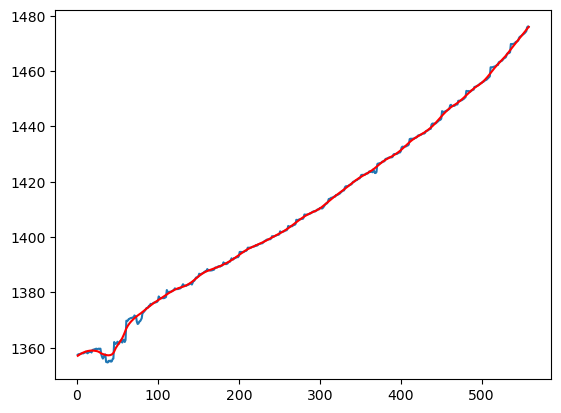

In [5]:
plt.plot(force15_df['Cycle'], force15_df['max.'])
plt.plot(resid_df['x'], fitted_value1, color='red')
plt.show()

In [9]:
# RLWR 알고리즘 파라미터 설정
f = 0.5
t = 2
n = len(resid_df)
r = 50
count = 1
x_s = sorted(resid_df['x'])
fitted_value = []


for x in x_s:
    h = get_n_th_distance(x, resid_df['x'], r)
    weights = tricube((x-resid_df['x'])/h)
    X = resid_df[['x']].copy()
    X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
    X = sm.add_constant(X)
    y = resid_df['y2']
    fit = sm.WLS(y, X, weights).fit()
    fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
    fitted_value.append(fitted_val)

fitted_value = np.array(fitted_value)

# 알고리즘 2~3단계 t번 반복
while count <= t:
    count += 1
    abs_residual = abs(resid_df['y2'] - fitted_value)
    s = np.median(abs_residual)
    delta = bisquare((resid_df['y2']-fitted_value)/(6*s))
    new_fitted_value = []
    for x in x_s:
        h = get_n_th_distance(x, resid_df['x'], r)
        weights = delta * tricube((x-resid_df['x'])/h)
        X = resid_df[['x']].copy()
        X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
        X = sm.add_constant(X)
        y = resid_df['y2']
        fit = sm.WLS(y, X, weights).fit()
        fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
        new_fitted_value.append(fitted_val)
    new_fitted_value = np.array(new_fitted_value)
    fitted_value2 = new_fitted_value

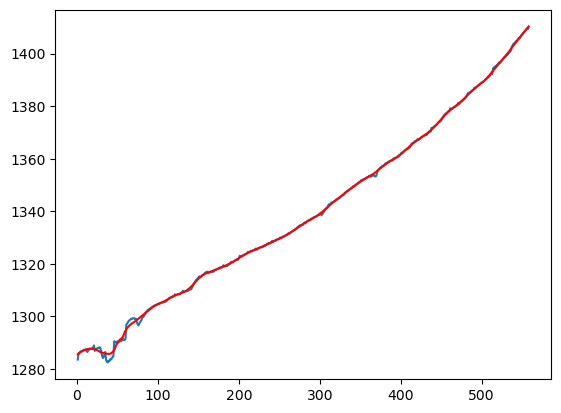

In [10]:
plt.plot(force15_df['Cycle'], force15_df['min.'])
plt.plot(resid_df['x'], fitted_value2, color='red')
plt.show()

In [11]:
# RLWR 알고리즘 파라미터 설정
f = 0.5
t = 2
n = len(resid_df)
r = 50
count = 1
x_s = sorted(resid_df['x'])
fitted_value = []


for x in x_s:
    h = get_n_th_distance(x, resid_df['x'], r)
    weights = tricube((x-resid_df['x'])/h)
    X = resid_df[['x']].copy()
    X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
    X = sm.add_constant(X)
    y = resid_df['y3']
    fit = sm.WLS(y, X, weights).fit()
    fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
    fitted_value.append(fitted_val)

fitted_value = np.array(fitted_value)

# 알고리즘 2~3단계 t번 반복
while count <= t:
    count += 1
    abs_residual = abs(resid_df['y3'] - fitted_value)
    s = np.median(abs_residual)
    delta = bisquare((resid_df['y3']-fitted_value)/(6*s))
    new_fitted_value = []
    for x in x_s:
        h = get_n_th_distance(x, resid_df['x'], r)
        weights = delta * tricube((x-resid_df['x'])/h)
        X = resid_df[['x']].copy()
        X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
        X = sm.add_constant(X)
        y = resid_df['y3']
        fit = sm.WLS(y, X, weights).fit()
        fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
        new_fitted_value.append(fitted_val)
    new_fitted_value = np.array(new_fitted_value)
    fitted_value3 = new_fitted_value

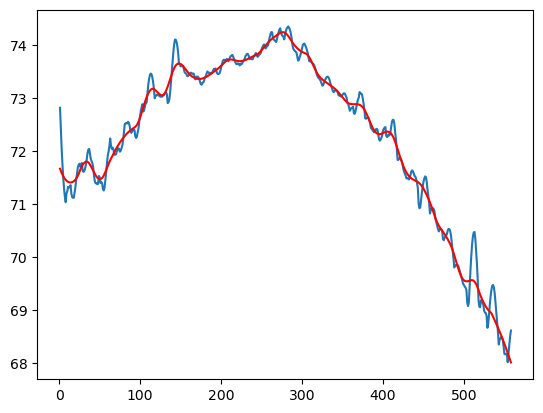

In [12]:
plt.plot(force15_df['Cycle'], force15_df['max.-min.'])
plt.plot(resid_df['x'], fitted_value3, color='red')
plt.show()

In [13]:
# RLWR 알고리즘 파라미터 설정
f = 0.5
t = 2
n = len(resid_df)
r = 50
count = 1
x_s = sorted(resid_df['x'])
fitted_value = []


for x in x_s:
    h = get_n_th_distance(x, resid_df['x'], r)
    weights = tricube((x-resid_df['x'])/h)
    X = resid_df[['x']].copy()
    X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
    X = sm.add_constant(X)
    y = resid_df['y4']
    fit = sm.WLS(y, X, weights).fit()
    fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
    fitted_value.append(fitted_val)

fitted_value = np.array(fitted_value)

# 알고리즘 2~3단계 t번 반복
while count <= t:
    count += 1
    abs_residual = abs(resid_df['y4'] - fitted_value)
    s = np.median(abs_residual)
    delta = bisquare((resid_df['y4']-fitted_value)/(6*s))
    new_fitted_value = []
    for x in x_s:
        h = get_n_th_distance(x, resid_df['x'], r)
        weights = delta * tricube((x-resid_df['x'])/h)
        X = resid_df[['x']].copy()
        X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
        X = sm.add_constant(X)
        y = resid_df['y4']
        fit = sm.WLS(y, X, weights).fit()
        fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
        new_fitted_value.append(fitted_val)
    new_fitted_value = np.array(new_fitted_value)
    fitted_value4 = new_fitted_value

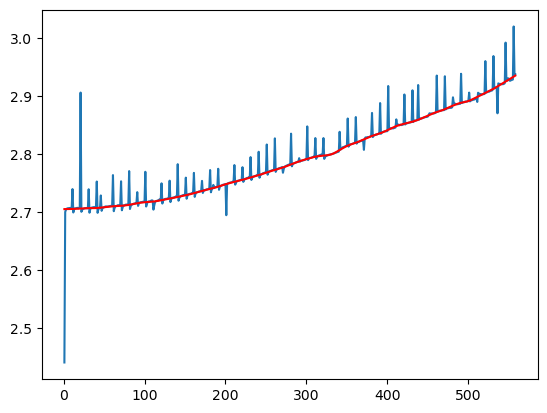

In [14]:
plt.plot(force15_df['Cycle'], force15_df['CIV'])
plt.plot(resid_df['x'], fitted_value4, color='red')
plt.show()

In [15]:
# RLWR 알고리즘 파라미터 설정
f = 0.5
t = 2
n = len(resid_df)
r = 50
count = 1
x_s = sorted(resid_df['x'])
fitted_value = []


for x in x_s:
    h = get_n_th_distance(x, resid_df['x'], r)
    weights = tricube((x-resid_df['x'])/h)
    X = resid_df[['x']].copy()
    X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
    X = sm.add_constant(X)
    y = resid_df['y5']
    fit = sm.WLS(y, X, weights).fit()
    fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
    fitted_value.append(fitted_val)

fitted_value = np.array(fitted_value)

# 알고리즘 2~3단계 t번 반복
while count <= t:
    count += 1
    abs_residual = abs(resid_df['y5'] - fitted_value)
    s = np.median(abs_residual)
    delta = bisquare((resid_df['y5']-fitted_value)/(6*s))
    new_fitted_value = []
    for x in x_s:
        h = get_n_th_distance(x, resid_df['x'], r)
        weights = delta * tricube((x-resid_df['x'])/h)
        X = resid_df[['x']].copy()
        X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
        X = sm.add_constant(X)
        y = resid_df['y5']
        fit = sm.WLS(y, X, weights).fit()
        fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
        new_fitted_value.append(fitted_val)
    new_fitted_value = np.array(new_fitted_value)
    fitted_value5 = new_fitted_value

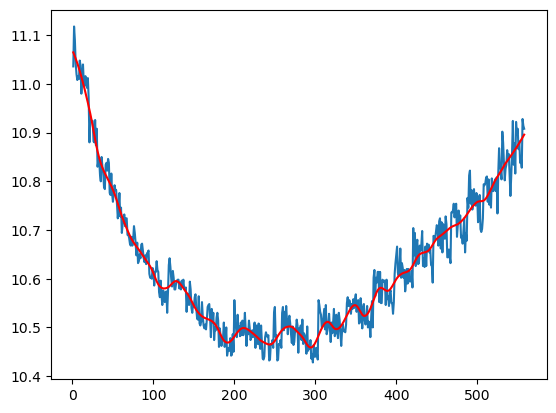

In [16]:
plt.plot(force15_df['Cycle'], force15_df['CCVIS'])
plt.plot(resid_df['x'], fitted_value5, color='red')
plt.show()

In [17]:
# RLWR 알고리즘 파라미터 설정
f = 0.5
t = 2
n = len(resid_df)
r = 50
count = 1
x_s = sorted(resid_df['x'])
fitted_value = []


for x in x_s:
    h = get_n_th_distance(x, resid_df['x'], r)
    weights = tricube((x-resid_df['x'])/h)
    X = resid_df[['x']].copy()
    X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
    X = sm.add_constant(X)
    y = resid_df['y6']
    fit = sm.WLS(y, X, weights).fit()
    fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
    fitted_value.append(fitted_val)

fitted_value = np.array(fitted_value)

# 알고리즘 2~3단계 t번 반복
while count <= t:
    count += 1
    abs_residual = abs(resid_df['y6'] - fitted_value)
    s = np.median(abs_residual)
    delta = bisquare((resid_df['y6']-fitted_value)/(6*s))
    new_fitted_value = []
    for x in x_s:
        h = get_n_th_distance(x, resid_df['x'], r)
        weights = delta * tricube((x-resid_df['x'])/h)
        X = resid_df[['x']].copy()
        X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
        X = sm.add_constant(X)
        y = resid_df['y6']
        fit = sm.WLS(y, X, weights).fit()
        fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
        new_fitted_value.append(fitted_val)
    new_fitted_value = np.array(new_fitted_value)
    fitted_value6 = new_fitted_value

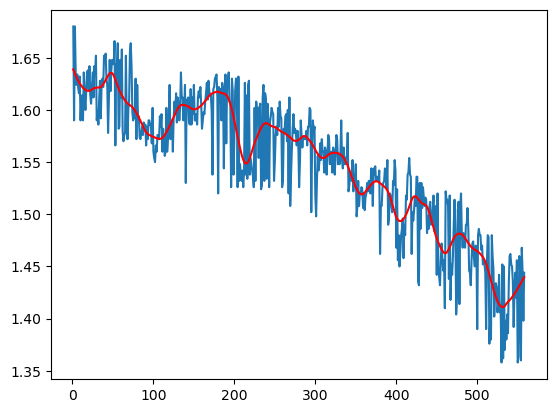

In [18]:
plt.plot(force15_df['Cycle'], force15_df['CCVES'])
plt.plot(resid_df['x'], fitted_value6, color='red')
plt.show()

In [19]:
# RLWR 알고리즘 파라미터 설정
f = 0.5
t = 2
n = len(resid_df)
r = 50
count = 1
x_s = sorted(resid_df['x'])
fitted_value = []


for x in x_s:
    h = get_n_th_distance(x, resid_df['x'], r)
    weights = tricube((x-resid_df['x'])/h)
    X = resid_df[['x']].copy()
    X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
    X = sm.add_constant(X)
    y = resid_df['y7']
    fit = sm.WLS(y, X, weights).fit()
    fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
    fitted_value.append(fitted_val)

fitted_value = np.array(fitted_value)

# 알고리즘 2~3단계 t번 반복
while count <= t:
    count += 1
    abs_residual = abs(resid_df['y7'] - fitted_value)
    s = np.median(abs_residual)
    delta = bisquare((resid_df['y7']-fitted_value)/(6*s))
    new_fitted_value = []
    for x in x_s:
        h = get_n_th_distance(x, resid_df['x'], r)
        weights = delta * tricube((x-resid_df['x'])/h)
        X = resid_df[['x']].copy()
        X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
        X = sm.add_constant(X)
        y = resid_df['y7']
        fit = sm.WLS(y, X, weights).fit()
        fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
        new_fitted_value.append(fitted_val)
    new_fitted_value = np.array(new_fitted_value)
    fitted_value7 = new_fitted_value

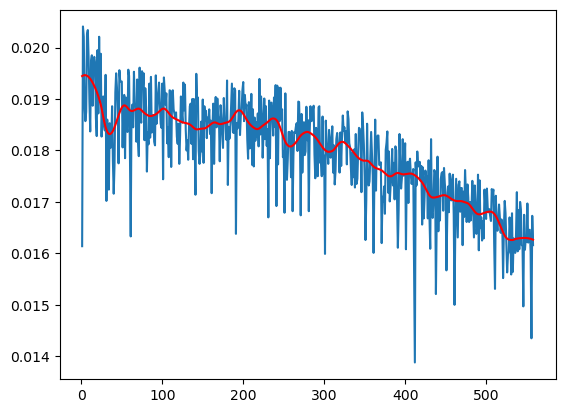

In [20]:
plt.plot(force15_df['Cycle'], force15_df['CVIS (dt)'])
plt.plot(resid_df['x'], fitted_value7, color='red')
plt.show()

In [21]:
# RLWR 알고리즘 파라미터 설정
f = 0.5
t = 2
n = len(resid_df)
r = 50
count = 1
x_s = sorted(resid_df['x'])
fitted_value = []


for x in x_s:
    h = get_n_th_distance(x, resid_df['x'], r)
    weights = tricube((x-resid_df['x'])/h)
    X = resid_df[['x']].copy()
    X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
    X = sm.add_constant(X)
    y = resid_df['y8']
    fit = sm.WLS(y, X, weights).fit()
    fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
    fitted_value.append(fitted_val)

fitted_value = np.array(fitted_value)

# 알고리즘 2~3단계 t번 반복
while count <= t:
    count += 1
    abs_residual = abs(resid_df['y8'] - fitted_value)
    s = np.median(abs_residual)
    delta = bisquare((resid_df['y8']-fitted_value)/(6*s))
    new_fitted_value = []
    for x in x_s:
        h = get_n_th_distance(x, resid_df['x'], r)
        weights = delta * tricube((x-resid_df['x'])/h)
        X = resid_df[['x']].copy()
        X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
        X = sm.add_constant(X)
        y = resid_df['y8']
        fit = sm.WLS(y, X, weights).fit()
        fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
        new_fitted_value.append(fitted_val)
    new_fitted_value = np.array(new_fitted_value)
    fitted_value8 = new_fitted_value

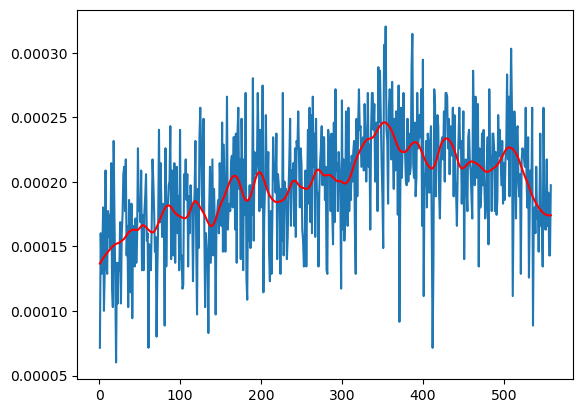

In [22]:
plt.plot(force15_df['Cycle'], force15_df['CVES (dt)'])
plt.plot(resid_df['x'], fitted_value8, color='red')
plt.show()

In [23]:
# RLWR 알고리즘 파라미터 설정
f = 0.5
t = 2
n = len(resid_df)
r = 50
count = 1
x_s = sorted(resid_df['x'])
fitted_value = []


for x in x_s:
    h = get_n_th_distance(x, resid_df['x'], r)
    weights = tricube((x-resid_df['x'])/h)
    X = resid_df[['x']].copy()
    X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
    X = sm.add_constant(X)
    y = resid_df['y9']
    fit = sm.WLS(y, X, weights).fit()
    fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
    fitted_value.append(fitted_val)

fitted_value = np.array(fitted_value)

# 알고리즘 2~3단계 t번 반복
while count <= t:
    count += 1
    abs_residual = abs(resid_df['y9'] - fitted_value)
    s = np.median(abs_residual)
    delta = bisquare((resid_df['y9']-fitted_value)/(6*s))
    new_fitted_value = []
    for x in x_s:
        h = get_n_th_distance(x, resid_df['x'], r)
        weights = delta * tricube((x-resid_df['x'])/h)
        X = resid_df[['x']].copy()
        X['x_squared'] = X['x'] ** 2  # 'X'의 제곱항 추가
        X = sm.add_constant(X)
        y = resid_df['y9']
        fit = sm.WLS(y, X, weights).fit()
        fitted_val = fit.params['const'] + fit.params['x']*x + fit.params['x_squared']*(x**2)  # 예측값 계산 시 'x'의 제곱항을 고려
        new_fitted_value.append(fitted_val)
    new_fitted_value = np.array(new_fitted_value)
    fitted_value9 = new_fitted_value

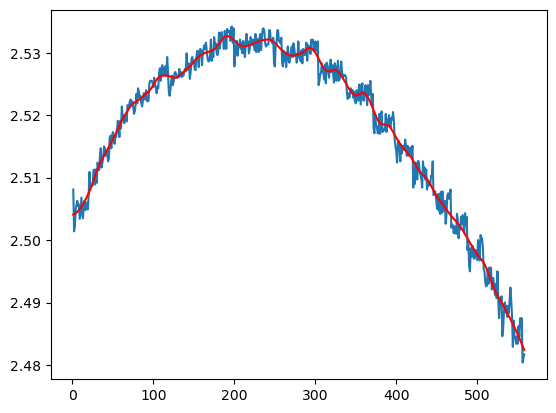

In [24]:
plt.plot(force15_df['Cycle'], force15_df['DIV'])
plt.plot(resid_df['x'], fitted_value9, color='red')
plt.show()

C:\Users\tlsdu\anaconda3\envs\mine\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


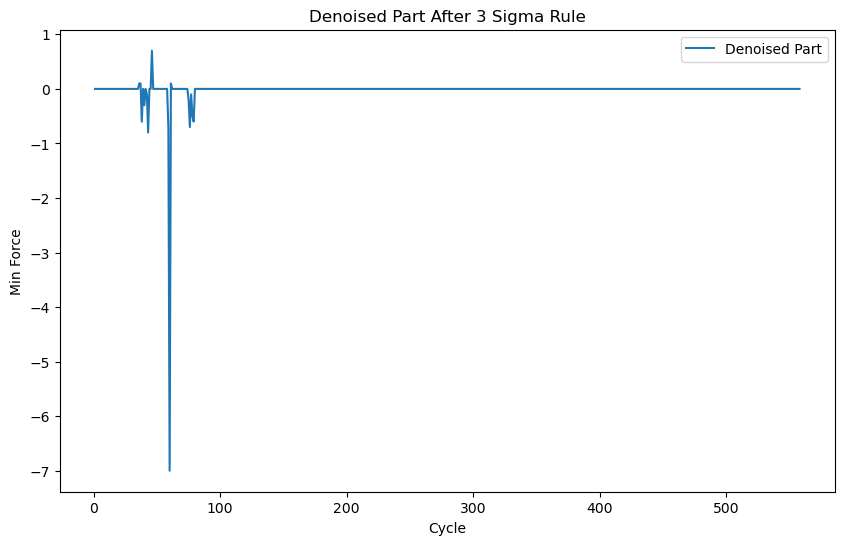

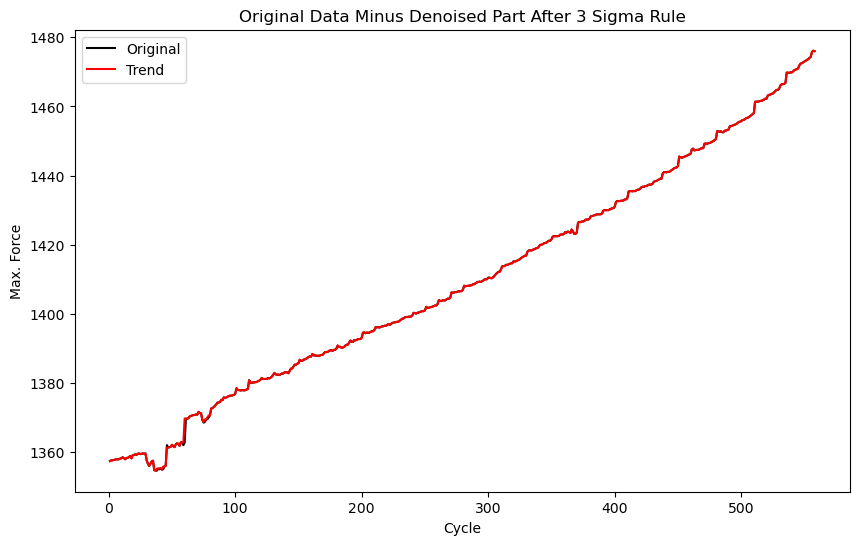

In [25]:
# 원본 데이터 저장
original_y = resid_df['y1'].copy()

# 이상치 처리
residuals = resid_df['y1'] - fitted_value1
s = np.std(residuals)
upper_bound = np.mean(residuals) + 3*s
lower_bound = np.mean(residuals) - 3*s
outliers = (residuals > upper_bound) | (residuals < lower_bound)

for i in range(len(resid_df)):
    if outliers[i]:
        if i == 0:
            nearest = i + 1
        elif i == len(resid_df) - 1:
            nearest = i - 1
        else:
            if abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i-1]) < abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i+1]):
                nearest = i - 1
            else:
                nearest = i + 1
        median = np.median(resid_df['y1'].iloc[nearest])
        resid_df['y1'].iloc[i] = median

# Denoised 부분 계산
denoised_y1 = original_y - resid_df['y1']

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], denoised_y1, label='Denoised Part')
plt.xlabel('Cycle')
plt.ylabel('Min Force')
plt.legend()
plt.title('Denoised Part After 3 Sigma Rule')
plt.show()

result_y1 = original_y - denoised_y1

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], original_y, label='Original', color='k')
plt.plot(resid_df['x'], result_y1, label='Trend', color='r')
plt.xlabel('Cycle')
plt.ylabel('Max. Force')
plt.legend()
plt.title('Original Data Minus Denoised Part After 3 Sigma Rule')
plt.show()

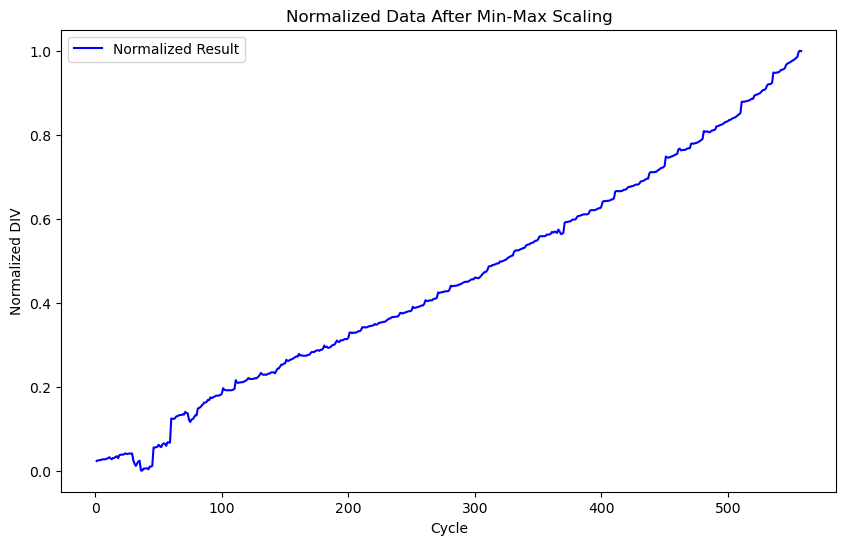

In [26]:
result_y_min = np.min(result_y1)
result_y_max = np.max(result_y1)

result_y_normalized1 = (result_y1 - result_y_min) / (result_y_max - result_y_min)

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], result_y_normalized1, label='Normalized Result', color='b')
plt.xlabel('Cycle')
plt.ylabel('Normalized DIV')
plt.legend()
plt.title('Normalized Data After Min-Max Scaling')
plt.show()

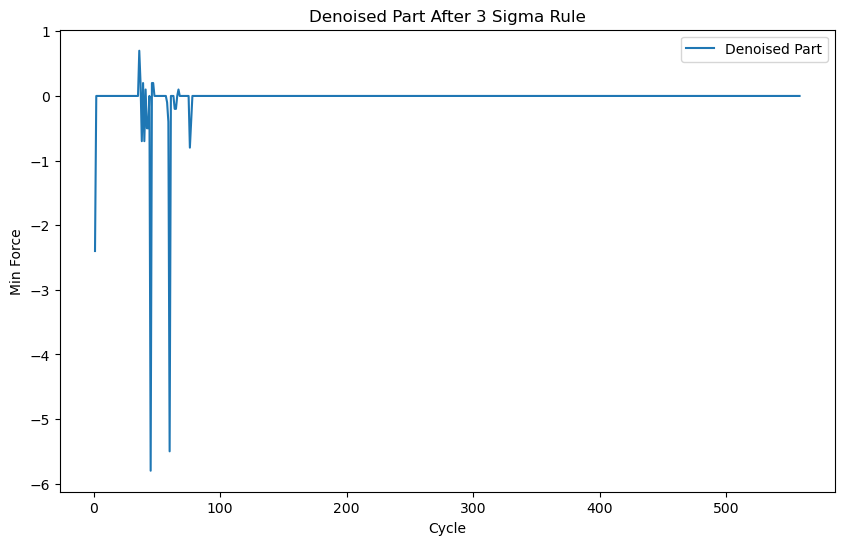

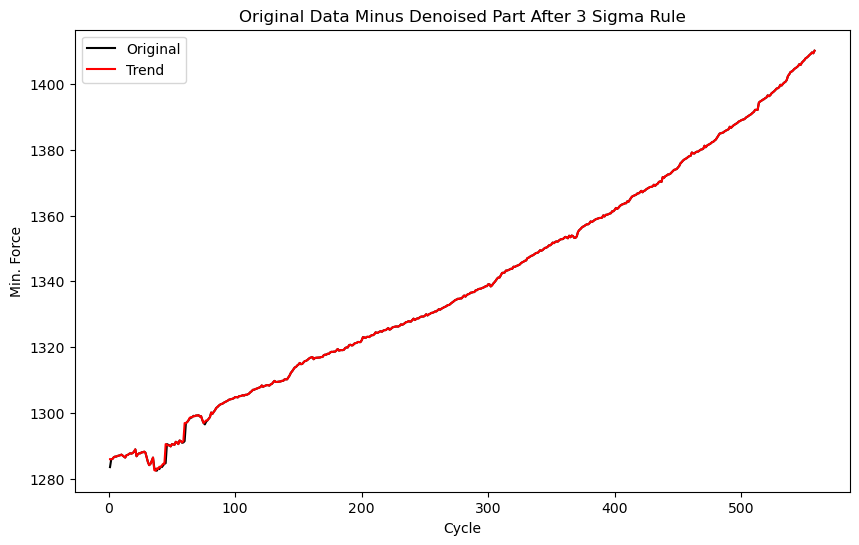

In [27]:
# 원본 데이터 저장
original_y = resid_df['y2'].copy()

# 이상치 처리
residuals = resid_df['y2'] - fitted_value2
s = np.std(residuals)
upper_bound = np.mean(residuals) + 3*s
lower_bound = np.mean(residuals) - 3*s
outliers = (residuals > upper_bound) | (residuals < lower_bound)

for i in range(len(resid_df)):
    if outliers[i]:
        if i == 0:
            nearest = i + 1
        elif i == len(resid_df) - 1:
            nearest = i - 1
        else:
            if abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i-1]) < abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i+1]):
                nearest = i - 1
            else:
                nearest = i + 1
        median = np.median(resid_df['y2'].iloc[nearest])
        resid_df['y2'].iloc[i] = median

# Denoised 부분 계산
denoised_y2 = original_y - resid_df['y2']

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], denoised_y2, label='Denoised Part')
plt.xlabel('Cycle')
plt.ylabel('Min Force')
plt.legend()
plt.title('Denoised Part After 3 Sigma Rule')
plt.show()

result_y2 = original_y - denoised_y2

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], original_y, label='Original', color='k')
plt.plot(resid_df['x'], result_y2, label='Trend', color='r')
plt.xlabel('Cycle')
plt.ylabel('Min. Force')
plt.legend()
plt.title('Original Data Minus Denoised Part After 3 Sigma Rule')
plt.show()

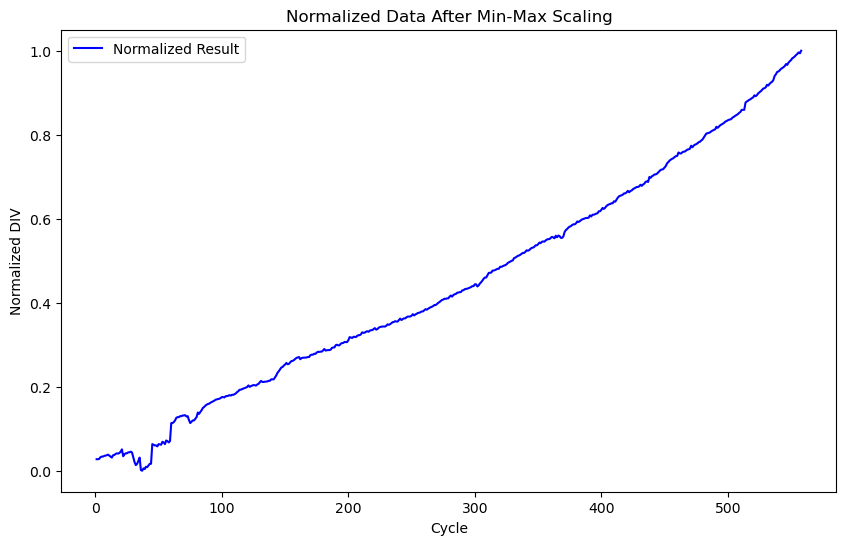

In [28]:
result_y_min = np.min(result_y2)
result_y_max = np.max(result_y2)

result_y_normalized2 = (result_y2 - result_y_min) / (result_y_max - result_y_min)

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], result_y_normalized2, label='Normalized Result', color='b')
plt.xlabel('Cycle')
plt.ylabel('Normalized DIV')
plt.legend()
plt.title('Normalized Data After Min-Max Scaling')
plt.show()

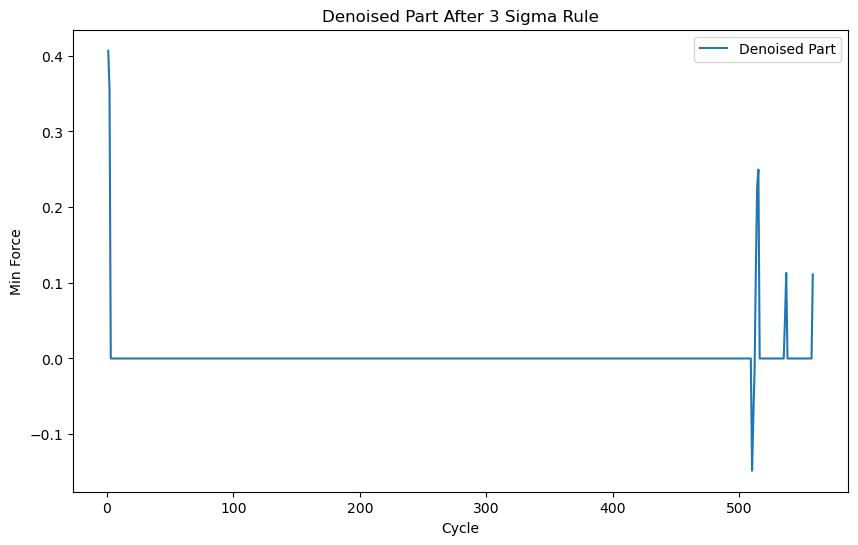

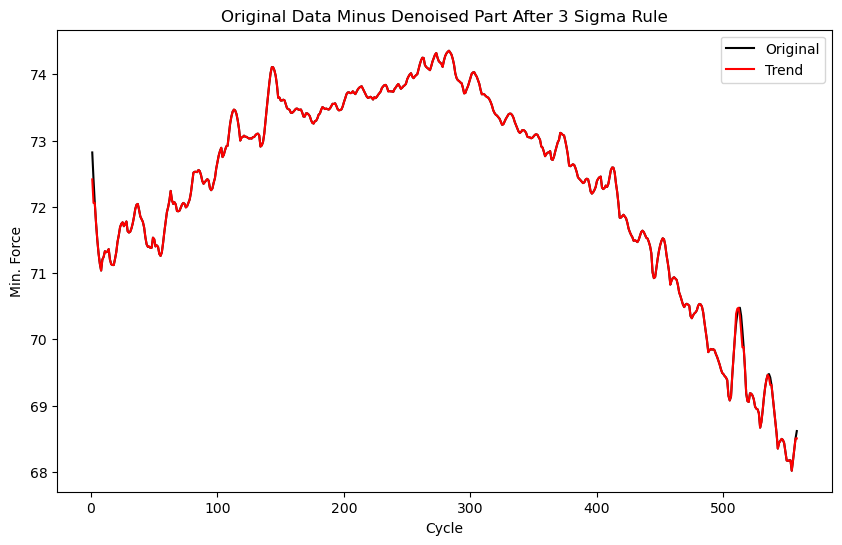

In [29]:
# 원본 데이터 저장
original_y = resid_df['y3'].copy()

# 이상치 처리
residuals = resid_df['y3'] - fitted_value3
s = np.std(residuals)
upper_bound = np.mean(residuals) + 3*s
lower_bound = np.mean(residuals) - 3*s
outliers = (residuals > upper_bound) | (residuals < lower_bound)

for i in range(len(resid_df)):
    if outliers[i]:
        if i == 0:
            nearest = i + 1
        elif i == len(resid_df) - 1:
            nearest = i - 1
        else:
            if abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i-1]) < abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i+1]):
                nearest = i - 1
            else:
                nearest = i + 1
        median = np.median(resid_df['y3'].iloc[nearest])
        resid_df['y3'].iloc[i] = median

# Denoised 부분 계산
denoised_y3 = original_y - resid_df['y3']

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], denoised_y3, label='Denoised Part')
plt.xlabel('Cycle')
plt.ylabel('Min Force')
plt.legend()
plt.title('Denoised Part After 3 Sigma Rule')
plt.show()

result_y3 = original_y - denoised_y3

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], original_y, label='Original', color='k')
plt.plot(resid_df['x'], result_y3, label='Trend', color='r')
plt.xlabel('Cycle')
plt.ylabel('Min. Force')
plt.legend()
plt.title('Original Data Minus Denoised Part After 3 Sigma Rule')
plt.show()

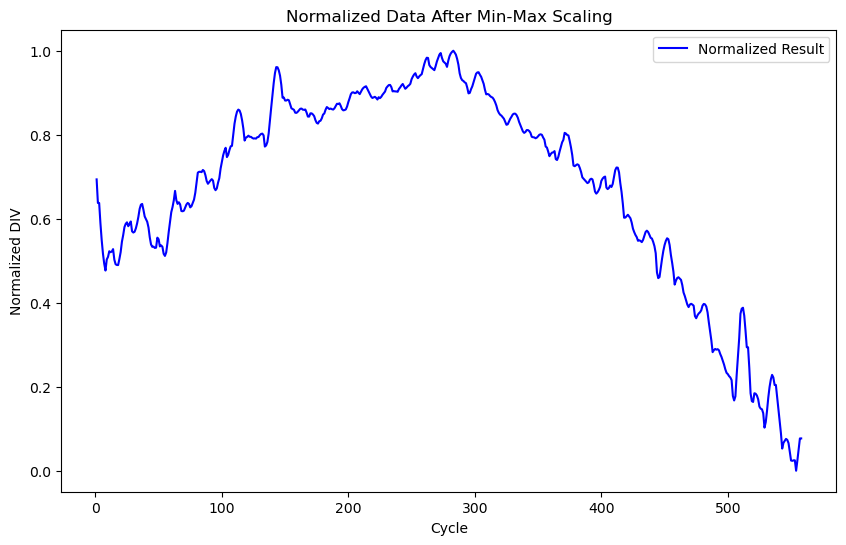

In [30]:
result_y_min = np.min(result_y3)
result_y_max = np.max(result_y3)

result_y_normalized3 = (result_y3 - result_y_min) / (result_y_max - result_y_min)

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], result_y_normalized3, label='Normalized Result', color='b')
plt.xlabel('Cycle')
plt.ylabel('Normalized DIV')
plt.legend()
plt.title('Normalized Data After Min-Max Scaling')
plt.show()

C:\Users\MSI\AppData\Local\Temp\ipykernel_30648\1120272176.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  resid_df['y4'].iloc[i] = median
C:\Users\MSI\AppData\Local\Temp\ipykernel_30648\1120272176.py:23: SettingWithCopyWarning: 
A valu

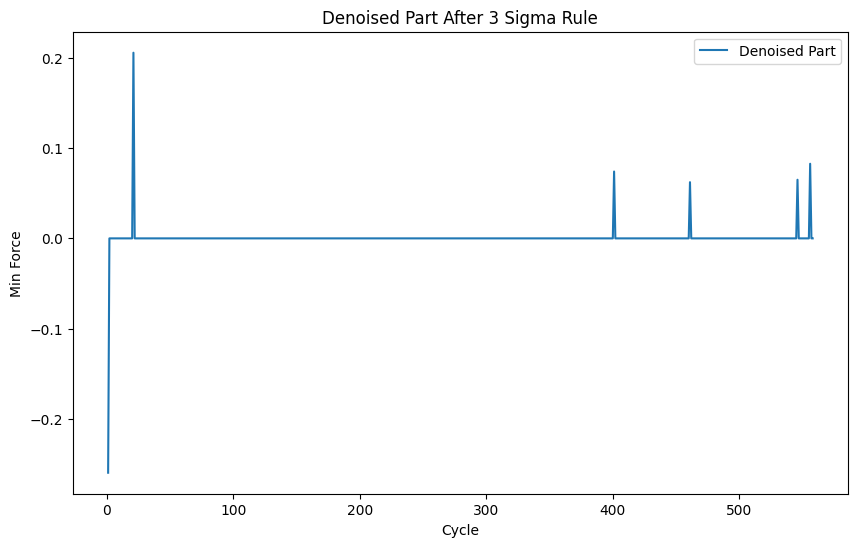

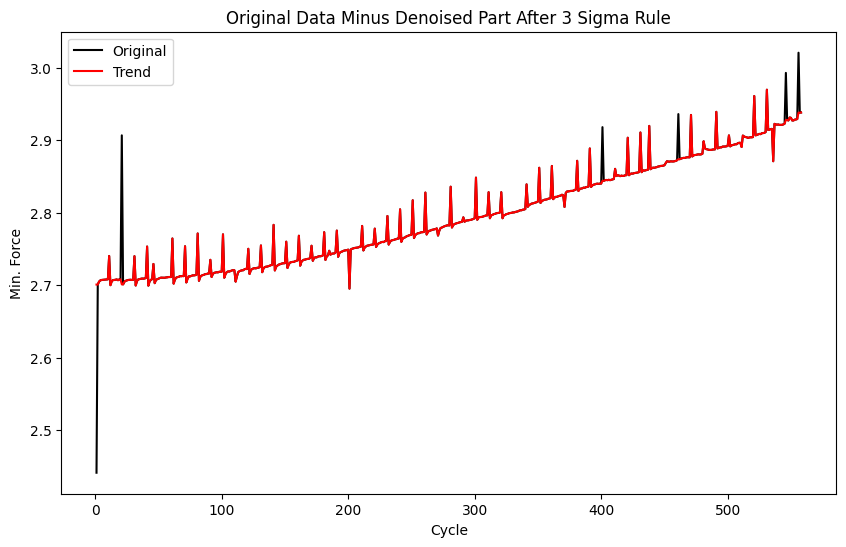

In [28]:
# 원본 데이터 저장
original_y = resid_df['y4'].copy()

# 이상치 처리
residuals = resid_df['y4'] - fitted_value4
s = np.std(residuals)
upper_bound = np.mean(residuals) + 3*s
lower_bound = np.mean(residuals) - 3*s
outliers = (residuals > upper_bound) | (residuals < lower_bound)

for i in range(len(resid_df)):
    if outliers[i]:
        if i == 0:
            nearest = i + 1
        elif i == len(resid_df) - 1:
            nearest = i - 1
        else:
            if abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i-1]) < abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i+1]):
                nearest = i - 1
            else:
                nearest = i + 1
        median = np.median(resid_df['y4'].iloc[nearest])
        resid_df['y4'].iloc[i] = median

# Denoised 부분 계산
denoised_y4 = original_y - resid_df['y4']

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], denoised_y4, label='Denoised Part')
plt.xlabel('Cycle')
plt.ylabel('Min Force')
plt.legend()
plt.title('Denoised Part After 3 Sigma Rule')
plt.show()

result_y4 = original_y - denoised_y4

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], original_y, label='Original', color='k')
plt.plot(resid_df['x'], result_y4, label='Trend', color='r')
plt.xlabel('Cycle')
plt.ylabel('Min. Force')
plt.legend()
plt.title('Original Data Minus Denoised Part After 3 Sigma Rule')
plt.show()

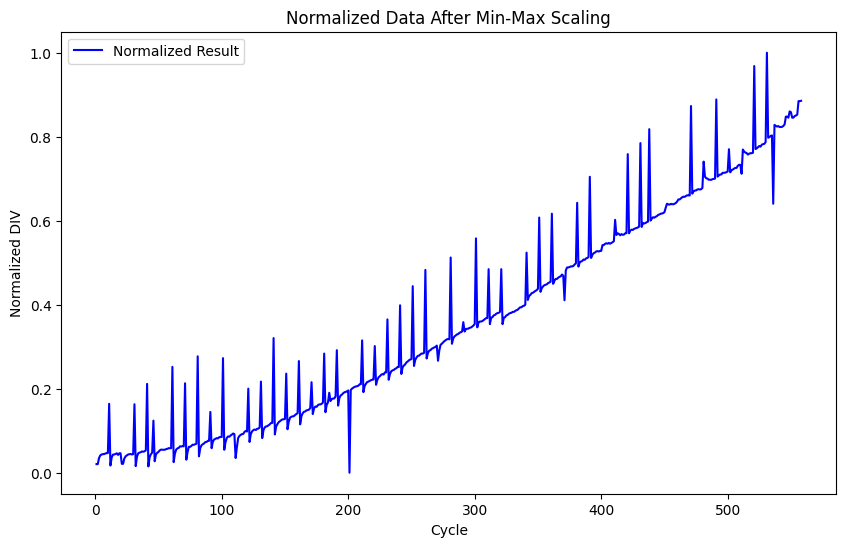

In [29]:
result_y_min = np.min(result_y4)
result_y_max = np.max(result_y4)

result_y_normalized4 = (result_y4 - result_y_min) / (result_y_max - result_y_min)

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], result_y_normalized4, label='Normalized Result', color='b')
plt.xlabel('Cycle')
plt.ylabel('Normalized DIV')
plt.legend()
plt.title('Normalized Data After Min-Max Scaling')
plt.show()

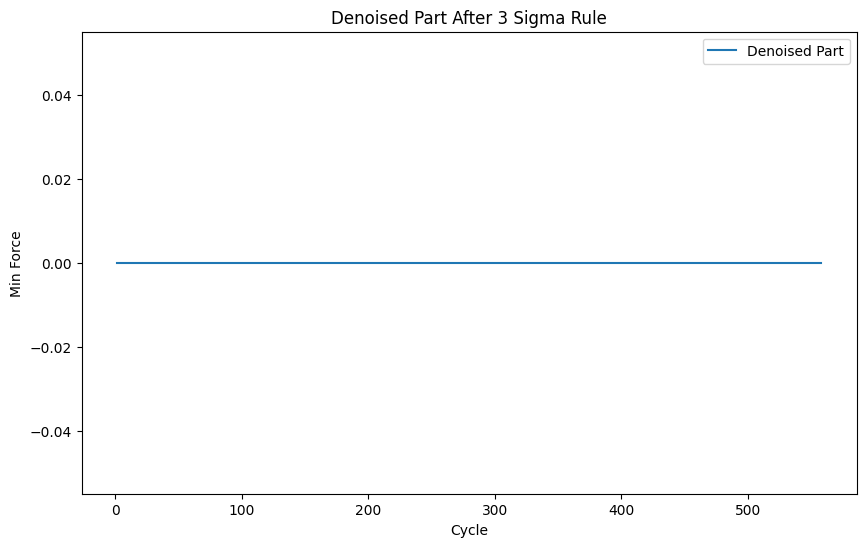

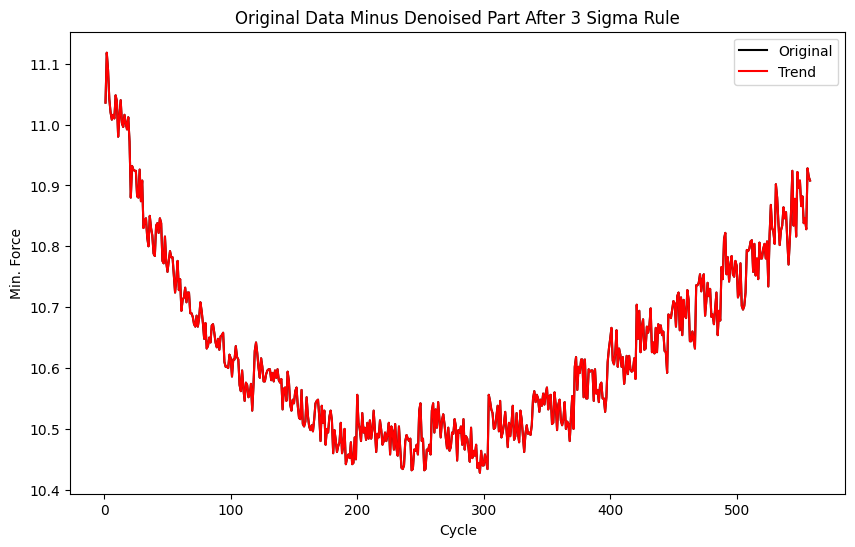

In [30]:
# 원본 데이터 저장
original_y = resid_df['y5'].copy()

# 이상치 처리
residuals = resid_df['y5'] - fitted_value5
s = np.std(residuals)
upper_bound = np.mean(residuals) + 3*s
lower_bound = np.mean(residuals) - 3*s
outliers = (residuals > upper_bound) | (residuals < lower_bound)

for i in range(len(resid_df)):
    if outliers[i]:
        if i == 0:
            nearest = i + 1
        elif i == len(resid_df) - 1:
            nearest = i - 1
        else:
            if abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i-1]) < abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i+1]):
                nearest = i - 1
            else:
                nearest = i + 1
        median = np.median(resid_df['y5'].iloc[nearest])
        resid_df['y5'].iloc[i] = median

# Denoised 부분 계산
denoised_y5 = original_y - resid_df['y5']

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], denoised_y5, label='Denoised Part')
plt.xlabel('Cycle')
plt.ylabel('Min Force')
plt.legend()
plt.title('Denoised Part After 3 Sigma Rule')
plt.show()

result_y5 = original_y - denoised_y5

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], original_y, label='Original', color='k')
plt.plot(resid_df['x'], result_y5, label='Trend', color='r')
plt.xlabel('Cycle')
plt.ylabel('Min. Force')
plt.legend()
plt.title('Original Data Minus Denoised Part After 3 Sigma Rule')
plt.show()

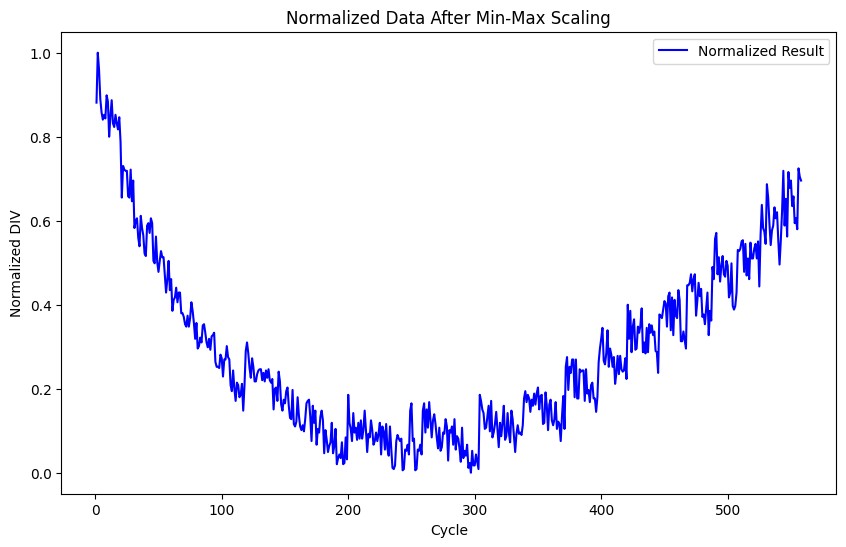

In [31]:
result_y_min = np.min(result_y5)
result_y_max = np.max(result_y5)

result_y_normalized5 = (result_y5 - result_y_min) / (result_y_max - result_y_min)

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], result_y_normalized5, label='Normalized Result', color='b')
plt.xlabel('Cycle')
plt.ylabel('Normalized DIV')
plt.legend()
plt.title('Normalized Data After Min-Max Scaling')
plt.show()

C:\Users\MSI\AppData\Local\Temp\ipykernel_30648\3845198001.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  resid_df['y6'].iloc[i] = median
C:\Users\MSI\AppData\Local\Temp\ipykernel_30648\3845198001.py:23: SettingWithCopyWarning: 
A valu

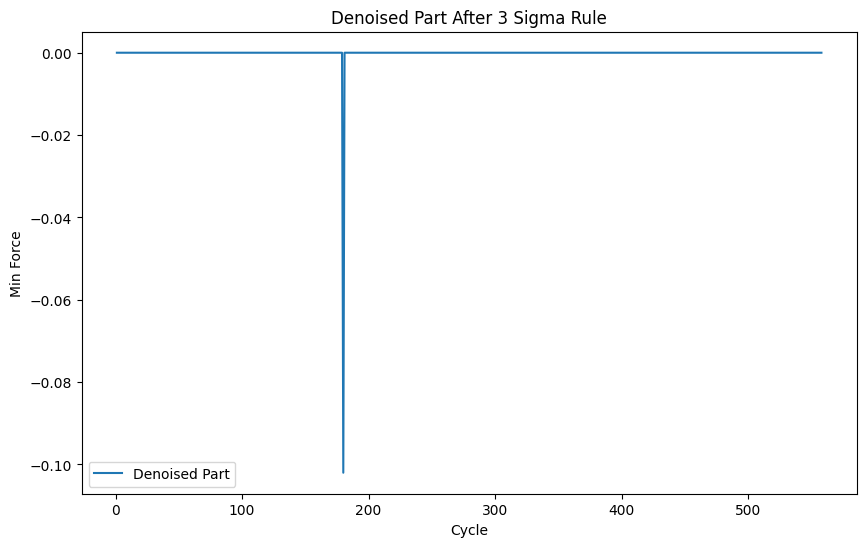

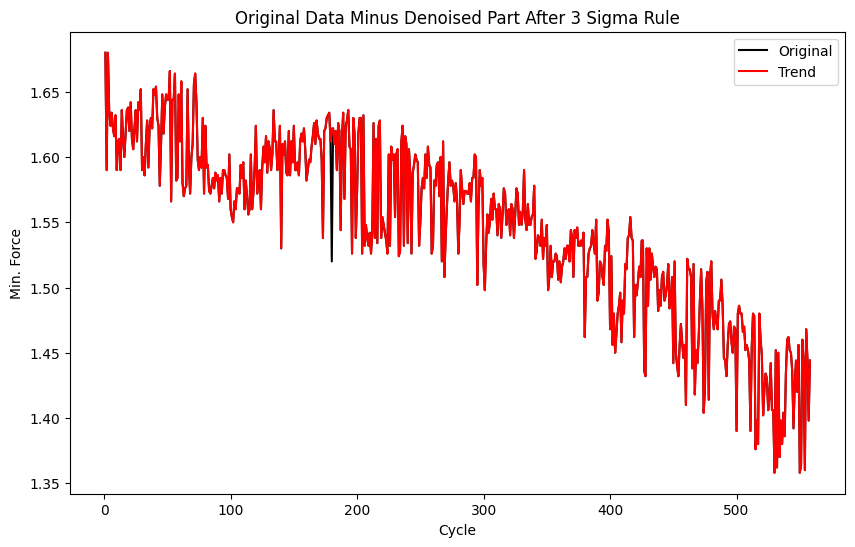

In [32]:
# 원본 데이터 저장
original_y = resid_df['y6'].copy()

# 이상치 처리
residuals = resid_df['y6'] - fitted_value6
s = np.std(residuals)
upper_bound = np.mean(residuals) + 3*s
lower_bound = np.mean(residuals) - 3*s
outliers = (residuals > upper_bound) | (residuals < lower_bound)

for i in range(len(resid_df)):
    if outliers[i]:
        if i == 0:
            nearest = i + 1
        elif i == len(resid_df) - 1:
            nearest = i - 1
        else:
            if abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i-1]) < abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i+1]):
                nearest = i - 1
            else:
                nearest = i + 1
        median = np.median(resid_df['y6'].iloc[nearest])
        resid_df['y6'].iloc[i] = median

# Denoised 부분 계산
denoised_y6 = original_y - resid_df['y6']

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], denoised_y6, label='Denoised Part')
plt.xlabel('Cycle')
plt.ylabel('Min Force')
plt.legend()
plt.title('Denoised Part After 3 Sigma Rule')
plt.show()

result_y6 = original_y - denoised_y6

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], original_y, label='Original', color='k')
plt.plot(resid_df['x'], result_y6, label='Trend', color='r')
plt.xlabel('Cycle')
plt.ylabel('Min. Force')
plt.legend()
plt.title('Original Data Minus Denoised Part After 3 Sigma Rule')
plt.show()

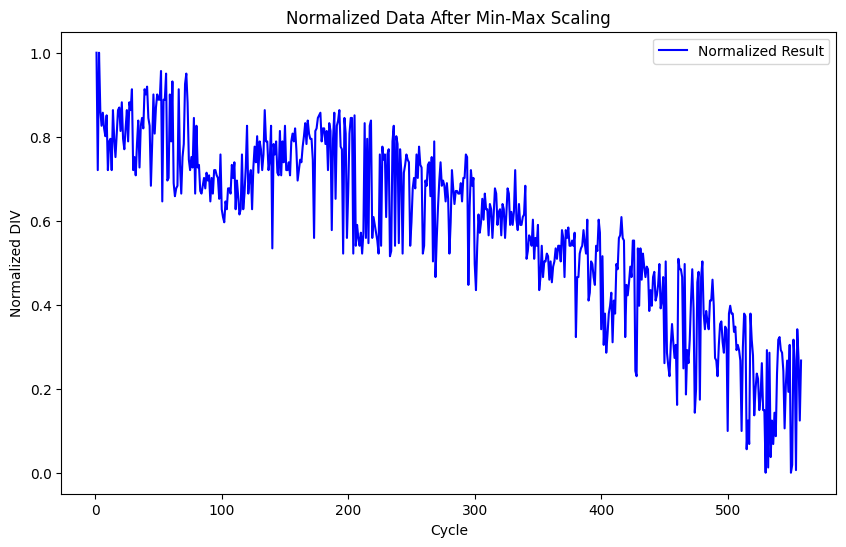

In [33]:
result_y_min = np.min(result_y6)
result_y_max = np.max(result_y6)

result_y_normalized6 = (result_y6 - result_y_min) / (result_y_max - result_y_min)

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], result_y_normalized6, label='Normalized Result', color='b')
plt.xlabel('Cycle')
plt.ylabel('Normalized DIV')
plt.legend()
plt.title('Normalized Data After Min-Max Scaling')
plt.show()

C:\Users\MSI\AppData\Local\Temp\ipykernel_30648\378723268.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  resid_df['y7'].iloc[i] = median
C:\Users\MSI\AppData\Local\Temp\ipykernel_30648\378723268.py:23: SettingWithCopyWarning: 
A value 

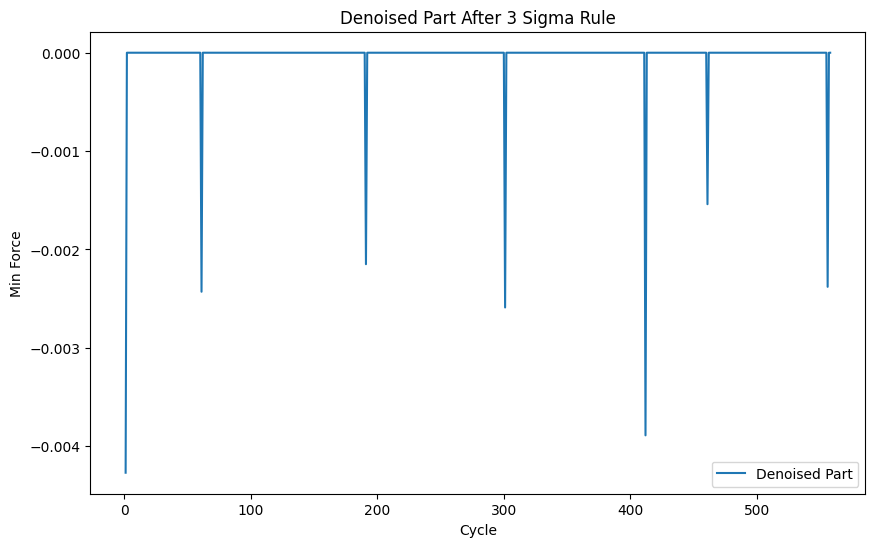

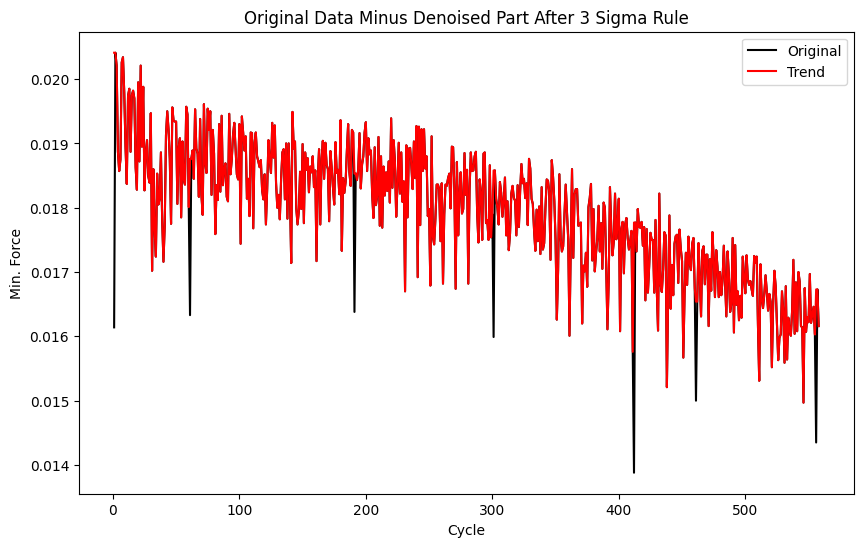

In [34]:
# 원본 데이터 저장
original_y = resid_df['y7'].copy()

# 이상치 처리
residuals = resid_df['y7'] - fitted_value7
s = np.std(residuals)
upper_bound = np.mean(residuals) + 3*s
lower_bound = np.mean(residuals) - 3*s
outliers = (residuals > upper_bound) | (residuals < lower_bound)

for i in range(len(resid_df)):
    if outliers[i]:
        if i == 0:
            nearest = i + 1
        elif i == len(resid_df) - 1:
            nearest = i - 1
        else:
            if abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i-1]) < abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i+1]):
                nearest = i - 1
            else:
                nearest = i + 1
        median = np.median(resid_df['y7'].iloc[nearest])
        resid_df['y7'].iloc[i] = median

# Denoised 부분 계산
denoised_y7 = original_y - resid_df['y7']

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], denoised_y7, label='Denoised Part')
plt.xlabel('Cycle')
plt.ylabel('Min Force')
plt.legend()
plt.title('Denoised Part After 3 Sigma Rule')
plt.show()

result_y7 = original_y - denoised_y7

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], original_y, label='Original', color='k')
plt.plot(resid_df['x'], result_y7, label='Trend', color='r')
plt.xlabel('Cycle')
plt.ylabel('Min. Force')
plt.legend()
plt.title('Original Data Minus Denoised Part After 3 Sigma Rule')
plt.show()

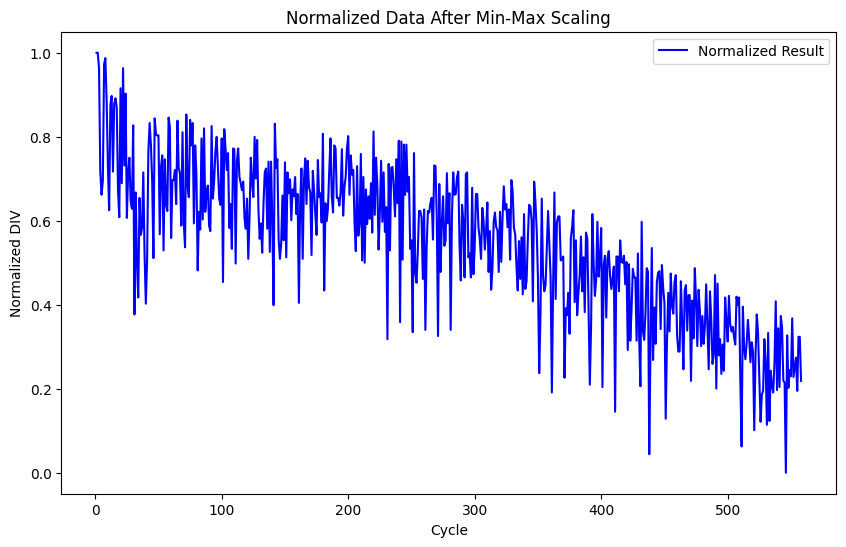

In [35]:
result_y_min = np.min(result_y7)
result_y_max = np.max(result_y7)

result_y_normalized7 = (result_y7 - result_y_min) / (result_y_max - result_y_min)

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], result_y_normalized7, label='Normalized Result', color='b')
plt.xlabel('Cycle')
plt.ylabel('Normalized DIV')
plt.legend()
plt.title('Normalized Data After Min-Max Scaling')
plt.show()

C:\Users\MSI\AppData\Local\Temp\ipykernel_30648\3686425855.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  resid_df['y8'].iloc[i] = median
C:\Users\MSI\AppData\Local\Temp\ipykernel_30648\3686425855.py:23: SettingWithCopyWarning: 
A valu

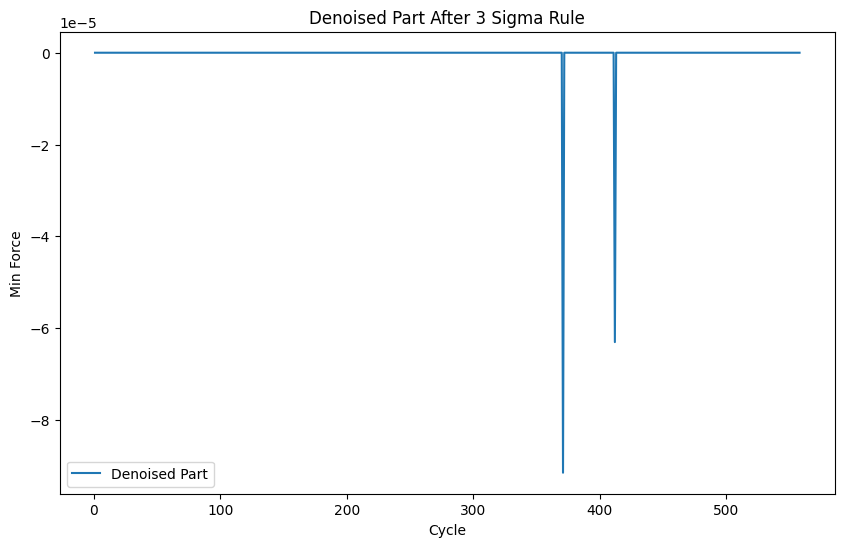

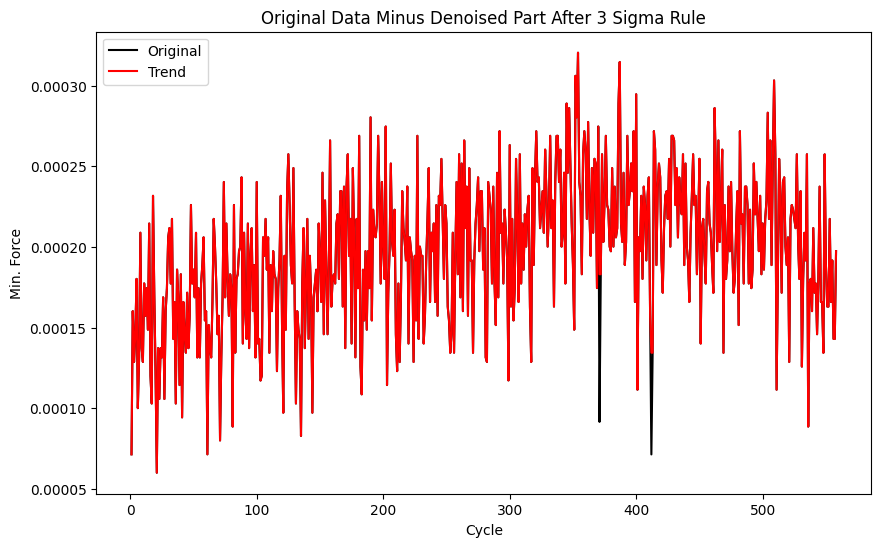

In [36]:
# 원본 데이터 저장
original_y = resid_df['y8'].copy()

# 이상치 처리
residuals = resid_df['y8'] - fitted_value8
s = np.std(residuals)
upper_bound = np.mean(residuals) + 3*s
lower_bound = np.mean(residuals) - 3*s
outliers = (residuals > upper_bound) | (residuals < lower_bound)

for i in range(len(resid_df)):
    if outliers[i]:
        if i == 0:
            nearest = i + 1
        elif i == len(resid_df) - 1:
            nearest = i - 1
        else:
            if abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i-1]) < abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i+1]):
                nearest = i - 1
            else:
                nearest = i + 1
        median = np.median(resid_df['y8'].iloc[nearest])
        resid_df['y8'].iloc[i] = median

# Denoised 부분 계산
denoised_y8 = original_y - resid_df['y8']

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], denoised_y8, label='Denoised Part')
plt.xlabel('Cycle')
plt.ylabel('Min Force')
plt.legend()
plt.title('Denoised Part After 3 Sigma Rule')
plt.show()

result_y8 = original_y - denoised_y8

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], original_y, label='Original', color='k')
plt.plot(resid_df['x'], result_y8, label='Trend', color='r')
plt.xlabel('Cycle')
plt.ylabel('Min. Force')
plt.legend()
plt.title('Original Data Minus Denoised Part After 3 Sigma Rule')
plt.show()

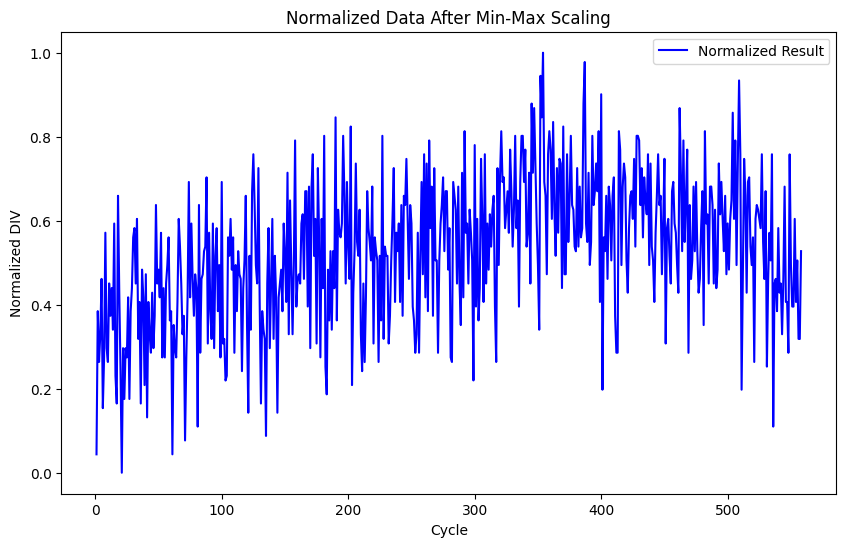

In [37]:
result_y_min = np.min(result_y8)
result_y_max = np.max(result_y8)

result_y_normalized8 = (result_y8 - result_y_min) / (result_y_max - result_y_min)

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], result_y_normalized8, label='Normalized Result', color='b')
plt.xlabel('Cycle')
plt.ylabel('Normalized DIV')
plt.legend()
plt.title('Normalized Data After Min-Max Scaling')
plt.show()

C:\Users\MSI\AppData\Local\Temp\ipykernel_30648\3103896403.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resid_df['y9'].iloc[i] = median
C:\Users\MSI\AppData\Local\Temp\ipykernel_30648\3103896403.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resid_df['y9'].iloc[i] = median


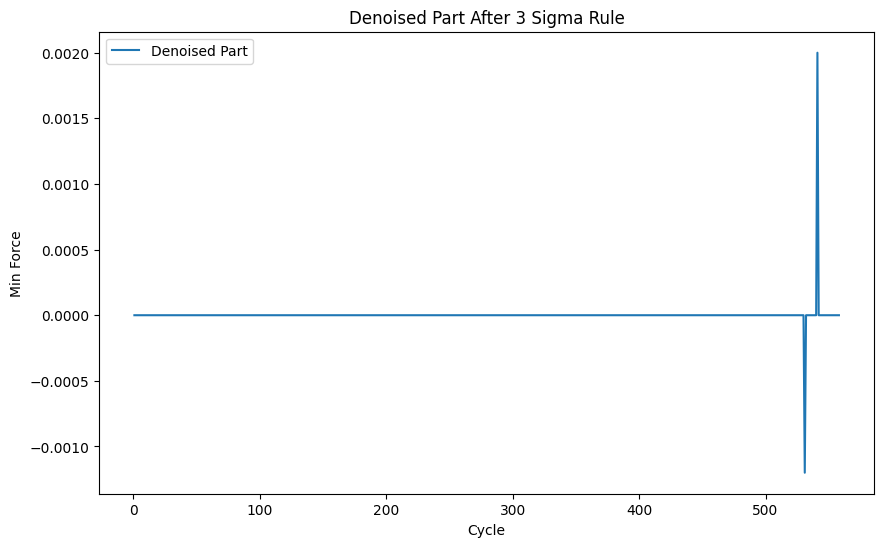

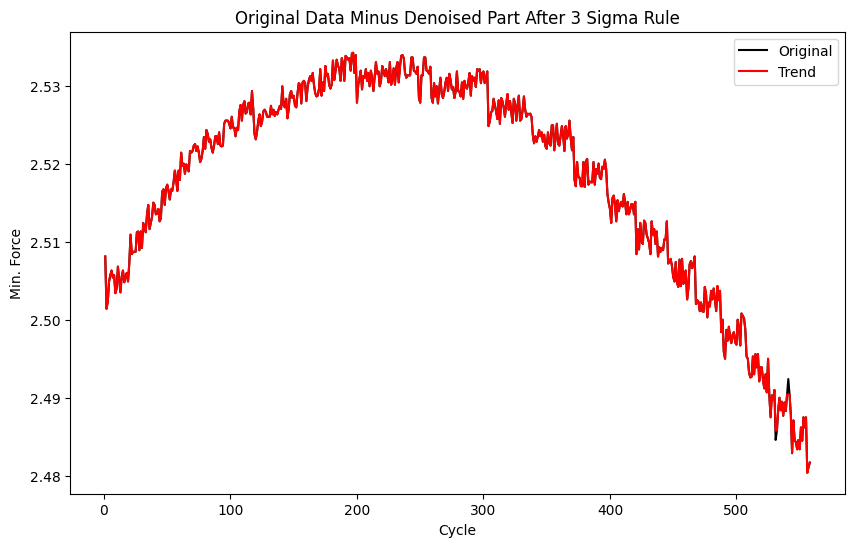

In [38]:
# 원본 데이터 저장
original_y = resid_df['y9'].copy()

# 이상치 처리
residuals = resid_df['y9'] - fitted_value9
s = np.std(residuals)
upper_bound = np.mean(residuals) + 3*s
lower_bound = np.mean(residuals) - 3*s
outliers = (residuals > upper_bound) | (residuals < lower_bound)

for i in range(len(resid_df)):
    if outliers[i]:
        if i == 0:
            nearest = i + 1
        elif i == len(resid_df) - 1:
            nearest = i - 1
        else:
            if abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i-1]) < abs(resid_df['x'].iloc[i] - resid_df['x'].iloc[i+1]):
                nearest = i - 1
            else:
                nearest = i + 1
        median = np.median(resid_df['y9'].iloc[nearest])
        resid_df['y9'].iloc[i] = median

# Denoised 부분 계산
denoised_y9 = original_y - resid_df['y9']

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], denoised_y9, label='Denoised Part')
plt.xlabel('Cycle')
plt.ylabel('Min Force')
plt.legend()
plt.title('Denoised Part After 3 Sigma Rule')
plt.show()

result_y9 = original_y - denoised_y9

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], original_y, label='Original', color='k')
plt.plot(resid_df['x'], result_y9, label='Trend', color='r')
plt.xlabel('Cycle')
plt.ylabel('Min. Force')
plt.legend()
plt.title('Original Data Minus Denoised Part After 3 Sigma Rule')
plt.show()

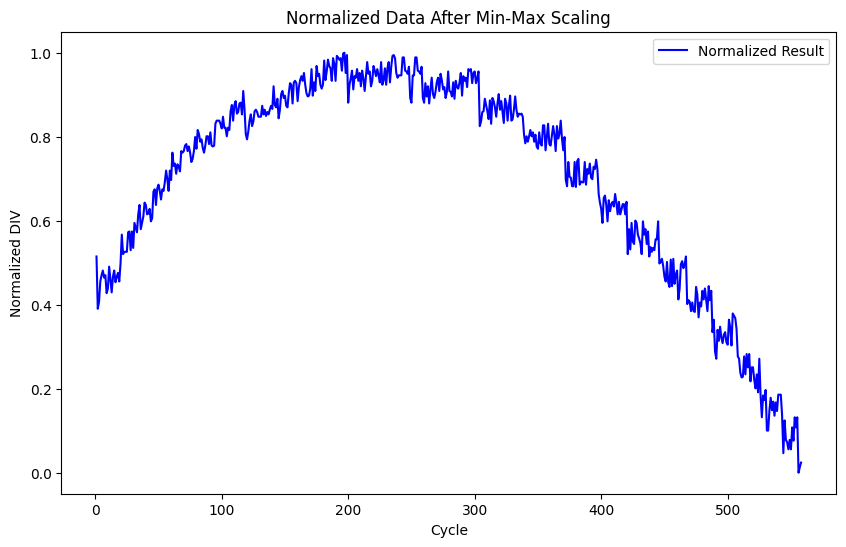

In [39]:
result_y_min = np.min(result_y9)
result_y_max = np.max(result_y9)

result_y_normalized9 = (result_y9 - result_y_min) / (result_y_max - result_y_min)

# 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(resid_df['x'], result_y_normalized9, label='Normalized Result', color='b')
plt.xlabel('Cycle')
plt.ylabel('Normalized DIV')
plt.legend()
plt.title('Normalized Data After Min-Max Scaling')
plt.show()

In [40]:
import tensorflow as tf
from tensorflow.keras import layers

encoder = tf.keras.models.Sequential([layers.Dense(6, activation='elu', input_shape=[9]),
                                      layers.Dense(4, activation='elu')])

decoder = tf.keras.models.Sequential([layers.Dense(6, activation='elu', input_shape=[4]),
                                      layers.Dense(9, activation='sigmoid')])
autoencoder = tf.keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam())

result_y_all = np.stack([result_y_normalized1, result_y_normalized2, result_y_normalized3, result_y_normalized4, result_y_normalized5, result_y_normalized6, result_y_normalized7, result_y_normalized8, result_y_normalized9], axis=1)

history = autoencoder.fit(result_y_all, result_y_all, epochs=30, batch_size=1)

reconstructed_all = autoencoder.predict(result_y_all)


Epoch 1/30
558/558 [==============================] - 2s 2ms/step - loss: 0.0419
Epoch 2/30
558/558 [==============================] - 1s 1ms/step - loss: 0.0094
Epoch 3/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0067
Epoch 4/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0062
Epoch 5/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0059
Epoch 6/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 7/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 8/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0056
Epoch 9/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0055
Epoch 10/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0053
Epoch 11/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0051
Epoch 12/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0049
Epoch 13/30
558/558 [====

In [41]:
reconstructed_all

array([[0.02266771, 0.02106954, 0.6075776 , ..., 0.82935965, 0.13474639,
        0.6152212 ],
       [0.02302599, 0.02231457, 0.5201163 , ..., 0.843501  , 0.3609605 ,
        0.5282826 ],
       [0.0202782 , 0.0192508 , 0.5474935 , ..., 0.8448075 , 0.23772375,
        0.553285  ],
       ...,
       [0.9042913 , 0.8994444 , 0.1346078 , ..., 0.23032214, 0.364     ,
        0.142109  ],
       [0.9185493 , 0.91321665, 0.13283838, ..., 0.22292687, 0.36257705,
        0.13981993],
       [0.9147775 , 0.9088162 , 0.14201914, ..., 0.25793317, 0.49856442,
        0.15241455]], dtype=float32)

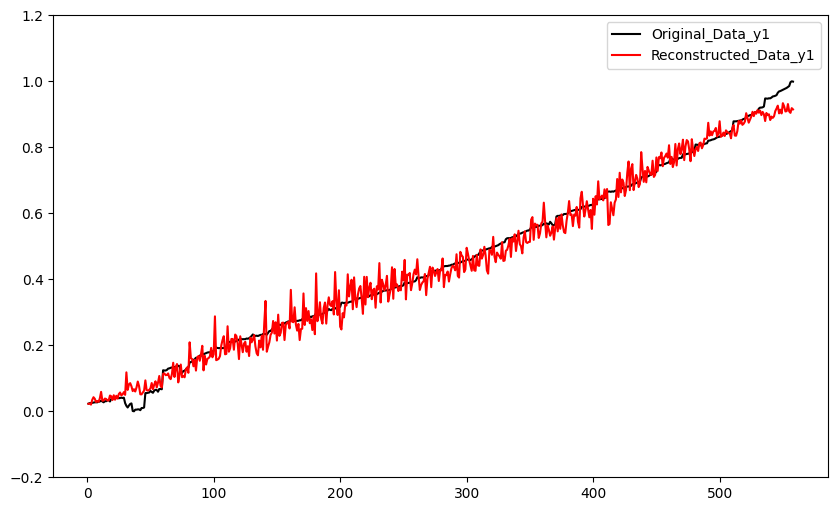

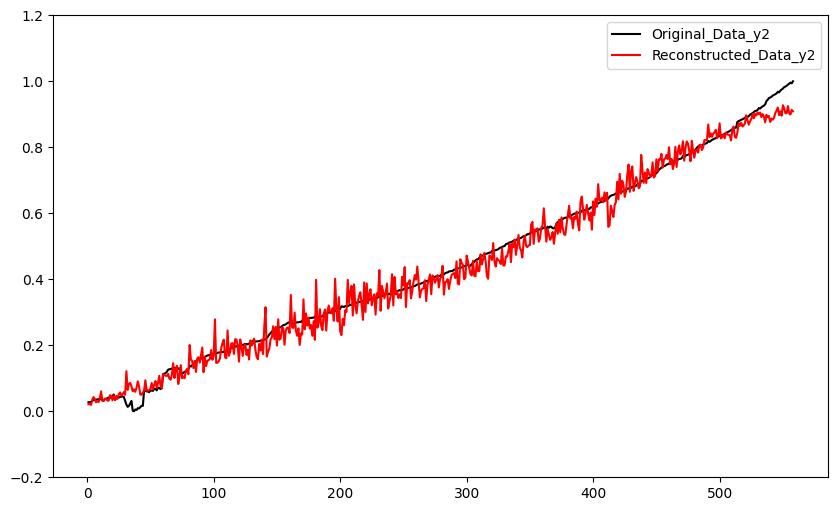

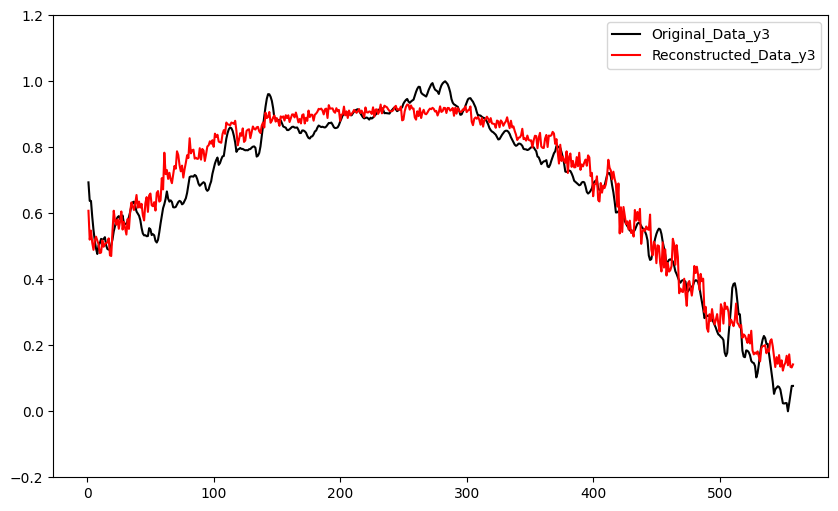

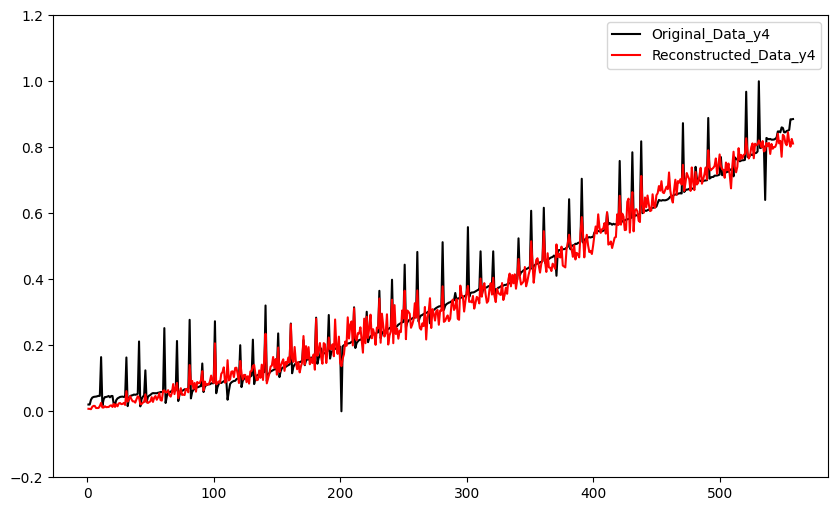

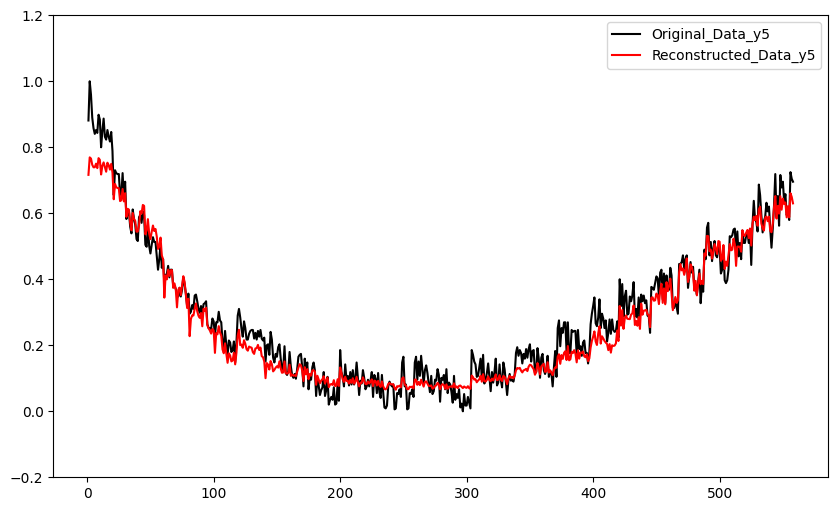

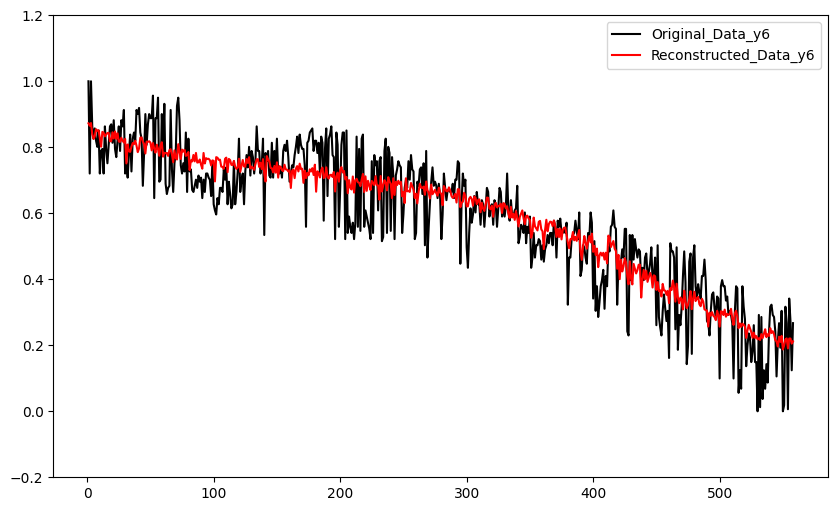

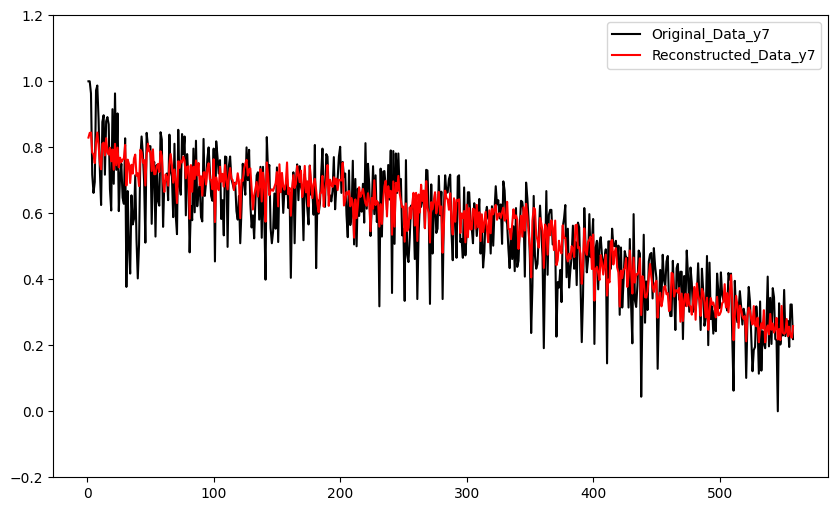

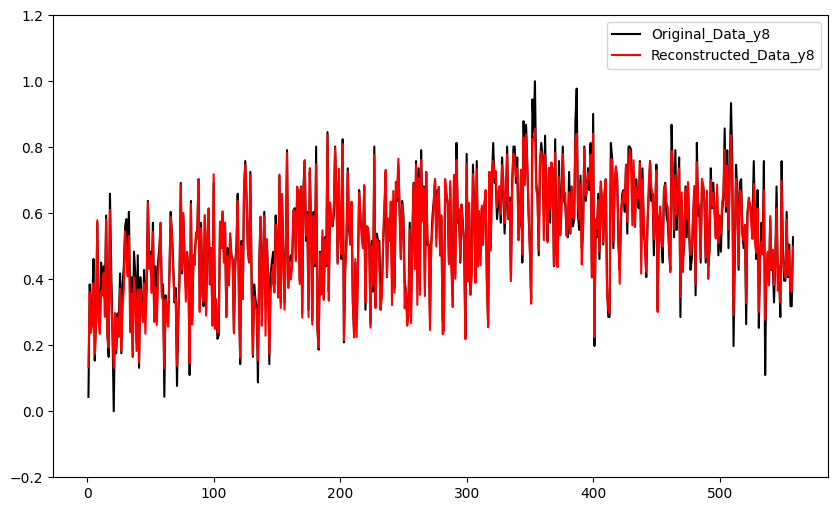

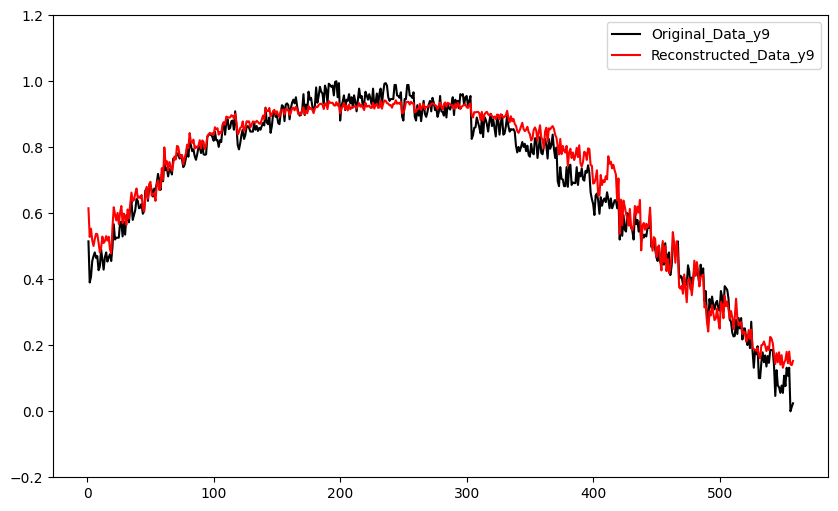

In [42]:
for i in range(9):
    plt.figure(figsize=(10,6))
    plt.plot(resid_df['x'], result_y_all[:,i], label=f'Original_Data_y{i+1}', color = 'black')
    plt.plot(resid_df['x'], reconstructed_all[:,i], label=f'Reconstructed_Data_y{i+1}', color='red')
    plt.ylim(-0.2,1.2)  # y축의 시작점을 0으로 설정
    plt.legend()
    plt.show()

RMSE for Mechanical: 0.0056501652165788984
RMSE for Impedance: 0.0060995441404303255
RMSE for All combined: 0.005858683351455108


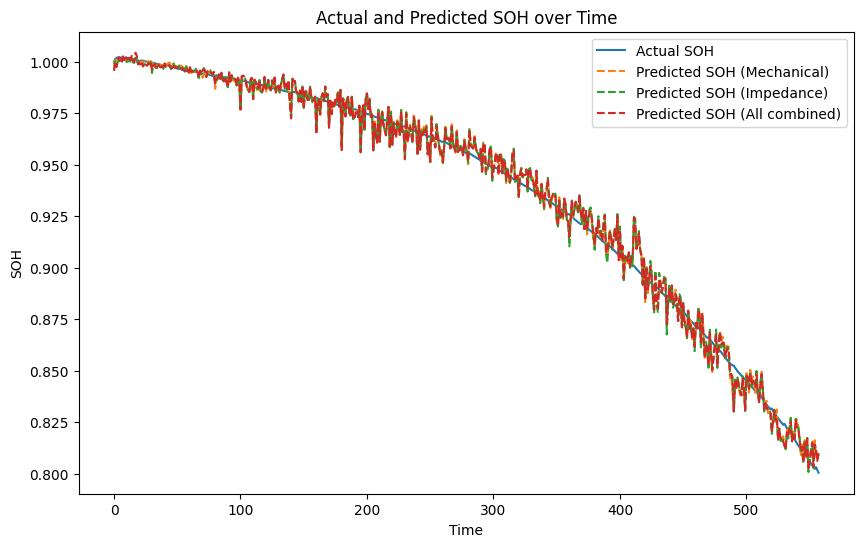

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
SOH_reshaped = np.array(SOH).reshape(-1, 1)
# 데이터 그룹 분류
mechanical = reconstructed_all[:, 0:3]
impedance = reconstructed_all[:, 3:9]
#multiphysics = reconstructed_all[:, 6:9]

# GPR 모델 정의
kernel = kernels.RBF() + kernels.WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)

# 결과를 저장할 리스트
predictions = []
rmses = []

# 각 데이터 그룹에 대해
for dataset in [mechanical, impedance, reconstructed_all]:
    # 데이터 분할 (80% 학습 데이터, 20% 테스트 데이터)
    X_train, X_test, y_train, y_test = train_test_split(dataset, SOH_reshaped, test_size=0.75, random_state=42)

    # GPR 학습
    gpr.fit(X_train, y_train)

    # 전체 기간에 대한 예측 수행
    SOH_pred = gpr.predict(dataset)
    predictions.append(SOH_pred)

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(SOH_reshaped, SOH_pred))
    rmses.append(rmse)

# 실제 SOH와 예측된 SOH를 시각화
plt.figure(figsize=(10,6))
plt.plot(range(len(SOH_reshaped)), SOH_reshaped, label='Actual SOH')

# 각 데이터 그룹에 대해
for i, label in enumerate(['Mechanical', 'Impedance', 'All combined']):
    plt.plot(range(len(predictions[i])), predictions[i], label=f'Predicted SOH ({label})', linestyle='dashed')
    print(f'RMSE for {label}: {rmses[i]}')

plt.xlabel('Time')
plt.ylabel('SOH')
plt.legend()
plt.title('Actual and Predicted SOH over Time')
plt.show()

RMSE for Mechanical: 0.06220544272407127
RMSE for Impedance: 0.04301020855361093
RMSE for Multiphysics: 0.060959052535542645
RMSE for All combined: 0.02864238703477679


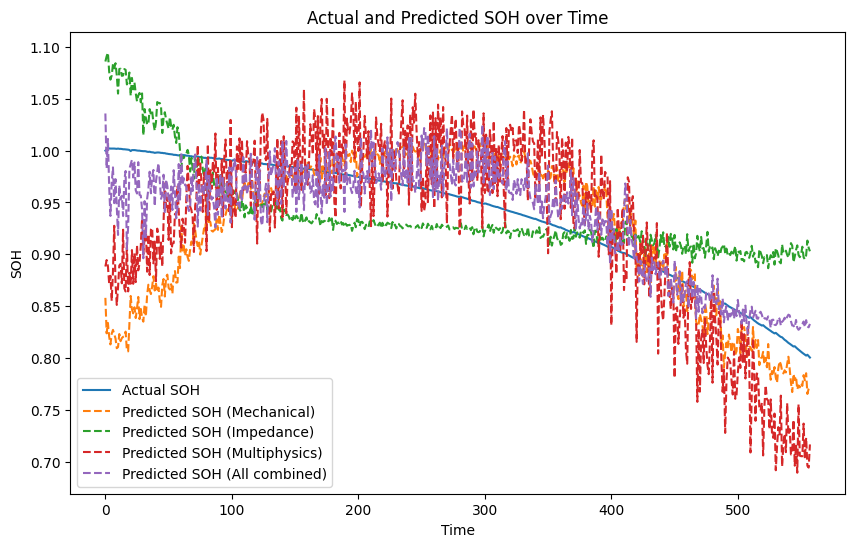

In [49]:
from sklearn.neural_network import MLPRegressor

SOH_reshaped = np.array(SOH).reshape(-1, 1)
# 데이터 그룹 분류
mechanical = reconstructed_all[:, 0:3]
impedance = reconstructed_all[:, 3:6]
multiphysics = reconstructed_all[:, 6:9]

# MLP 모델 정의
mlp = MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='adam', max_iter=200)

# 결과를 저장할 리스트
predictions = []
rmses = []

# 각 데이터 그룹에 대해
for dataset in [mechanical, impedance, multiphysics, reconstructed_all]:
    # 데이터 분할 (80% 학습 데이터, 20% 테스트 데이터)
    X_train, X_test, y_train, y_test = train_test_split(dataset, SOH_reshaped, test_size=0.5, random_state=42)

    # MLP 학습
    mlp.fit(X_train, y_train.ravel())

    # 전체 기간에 대한 예측 수행
    SOH_pred = mlp.predict(dataset)
    predictions.append(SOH_pred)

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(SOH_reshaped, SOH_pred))
    rmses.append(rmse)

# 실제 SOH와 예측된 SOH를 시각화
plt.figure(figsize=(10,6))
plt.plot(range(len(SOH_reshaped)), SOH_reshaped, label='Actual SOH')

# 각 데이터 그룹에 대해
for i, label in enumerate(['Mechanical', 'Impedance', 'Multiphysics', 'All combined']):
    plt.plot(range(len(predictions[i])), predictions[i], label=f'Predicted SOH ({label})', linestyle='dashed')
    print(f'RMSE for {label}: {rmses[i]}')

plt.xlabel('Time')
plt.ylabel('SOH')
plt.legend()
plt.title('Actual and Predicted SOH over Time')
plt.show()

18/18 [==============================] - 0s 2ms/step
RMSE for Mechanical: 0.010917583437777472
RMSE for Impedance: 0.01085209668260949
RMSE for Multiphysics: 0.008789518926515562
RMSE for All combined: 0.015607231425344535


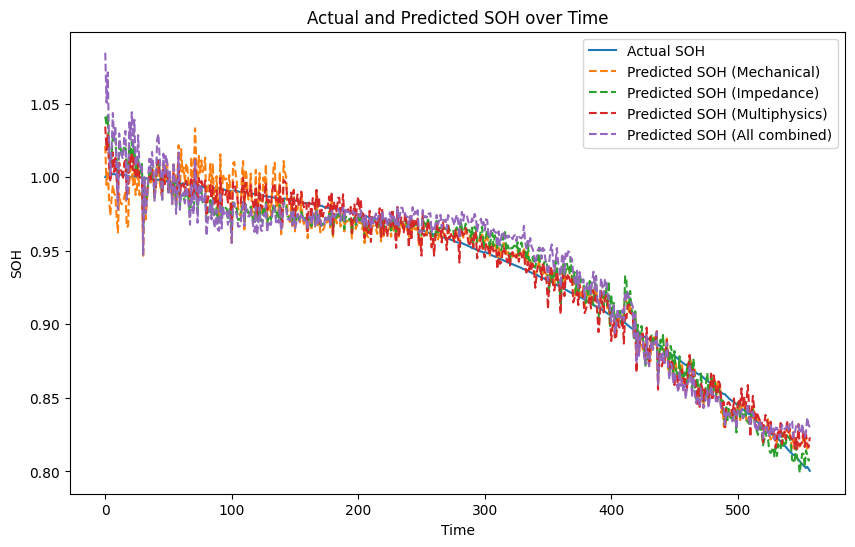

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

SOH_reshaped = np.array(SOH).reshape(-1, 1)
# 데이터 그룹 분류
mechanical = reconstructed_all[:, 0:3]
impedance = reconstructed_all[:, 3:6]
multiphysics = reconstructed_all[:, 6:9]

# 결과를 저장할 리스트
predictions = []
rmses = []

# 각 데이터 그룹에 대해
for dataset in [mechanical, impedance, multiphysics, reconstructed_all]:
    # LSTM 모델 정의
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(1, dataset.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # 데이터 분할 (80% 학습 데이터, 20% 테스트 데이터)
    X_train, X_test, y_train, y_test = train_test_split(dataset, SOH_reshaped, test_size=0.2, random_state=42)

    # 데이터 재구성
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # LSTM 학습
    model.fit(X_train, y_train, epochs=200, verbose=0)

    # 전체 기간에 대한 예측 수행
    SOH_pred = model.predict(dataset.reshape((dataset.shape[0], 1, dataset.shape[1])))
    predictions.append(SOH_pred)

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(SOH_reshaped, SOH_pred))
    rmses.append(rmse)

# 실제 SOH와 예측된 SOH를 시각화
plt.figure(figsize=(10,6))
plt.plot(range(len(SOH_reshaped)), SOH_reshaped, label='Actual SOH')

# 각 데이터 그룹에 대해
for i, label in enumerate(['Mechanical', 'Impedance', 'Multiphysics', 'All combined']):
    plt.plot(range(len(predictions[i])), predictions[i], label=f'Predicted SOH ({label})', linestyle='dashed')
    print(f'RMSE for {label}: {rmses[i]}')

plt.xlabel('Time')
plt.ylabel('SOH')
plt.legend()
plt.title('Actual and Predicted SOH over Time')
plt.show()

18/18 [==============================] - 0s 2ms/step
RMSE for Mechanical: 0.010660847019340452
RMSE for Impedance: 0.007613588051544562
RMSE for Multiphysics: 0.007424880333299671
RMSE for All combined: 0.006126561786697145


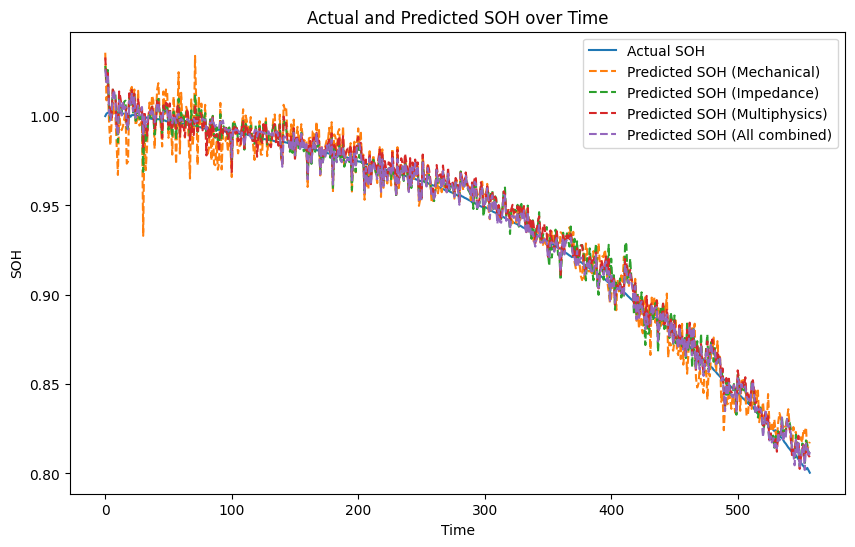

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense

SOH_reshaped = np.array(SOH).reshape(-1, 1)
# 데이터 그룹 분류
mechanical = reconstructed_all[:, 0:3]
impedance = reconstructed_all[:, 3:6]
multiphysics = reconstructed_all[:, 6:9]

# 결과를 저장할 리스트
predictions = []
rmses = []

# 각 데이터 그룹에 대해
for dataset in [mechanical, impedance, multiphysics, reconstructed_all]:
    # 1D-CNN 모델 정의
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(dataset.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # 데이터 분할 (80% 학습 데이터, 20% 테스트 데이터)
    X_train, X_test, y_train, y_test = train_test_split(dataset, SOH_reshaped, test_size=0.2, random_state=42)

    # 데이터 재구성
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # 1D-CNN 학습
    model.fit(X_train, y_train, epochs=200, verbose=0)

    # 전체 기간에 대한 예측 수행
    SOH_pred = model.predict(dataset.reshape((dataset.shape[0], dataset.shape[1], 1)))
    predictions.append(SOH_pred)

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(SOH_reshaped, SOH_pred))
    rmses.append(rmse)

# 실제 SOH와 예측된 SOH를 시각화
plt.figure(figsize=(10,6))
plt.plot(range(len(SOH_reshaped)), SOH_reshaped, label='Actual SOH')

# 각 데이터 그룹에 대해
for i, label in enumerate(['Mechanical', 'Impedance', 'Multiphysics', 'All combined']):
    plt.plot(range(len(predictions[i])), predictions[i], label=f'Predicted SOH ({label})', linestyle='dashed')
    print(f'RMSE for {label}: {rmses[i]}')

plt.xlabel('Time')
plt.ylabel('SOH')
plt.legend()
plt.title('Actual and Predicted SOH over Time')
plt.show()